<a href="https://colab.research.google.com/github/oluwadamilola/Topic-Modelling/blob/development/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.

singnal financial news dataset -

#import Libraries

In [2]:
!pip install pyLDAvis

In [3]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:

import nltk
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import nltk
nltk.download('wordnet')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# The Data Preprocessing

*   cnbc data as the news data for this experiment




In [7]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/cnbc_headlines.csv")

# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
#data = data.Description.str.replace("[^A-Za-z ]", " ")

data.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Headlines  \
0  Jim Cramer: A better way to invest in the Covi...   
1     Cramer's lightning round: I would own Teradyne   
2                                                NaN   
3  Cramer's week ahead: Big week for earnings, ev...   
4  IQ Capital CEO Keith Bliss says tech and healt...   

                             Time  \
0   7:51  PM ET Fri, 17 July 2020   
1   7:33  PM ET Fri, 17 July 2020   
2                             NaN   
3   7:25  PM ET Fri, 17 July 2020   
4   4:24  PM ET Fri, 17 July 2020   

                                         Description  
0  "Mad Money" host Jim Cramer recommended buying...  
1  "Mad Money" host Jim Cramer rings the lightnin...  
2                                                NaN  
3  "We'll pay more for the earnings of the non-Co...  
4  Keith Bliss, IQ Capital CEO, joins "Closing Be...

In [8]:
print(data.columns)

Index(['Headlines', 'Time', 'Description'], dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#drop NAN values
data = data.dropna()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Headlines  \
0  Jim Cramer: A better way to invest in the Covi...   
1     Cramer's lightning round: I would own Teradyne   
3  Cramer's week ahead: Big week for earnings, ev...   
4  IQ Capital CEO Keith Bliss says tech and healt...   
5  Wall Street delivered the 'kind of pullback I'...   

                             Time  \
0   7:51  PM ET Fri, 17 July 2020   
1   7:33  PM ET Fri, 17 July 2020   
3   7:25  PM ET Fri, 17 July 2020   
4   4:24  PM ET Fri, 17 July 2020   
5   7:36  PM ET Thu, 16 July 2020   

                                         Description  
0  "Mad Money" host Jim Cramer recommended buying...  
1  "Mad Money" host Jim Cramer rings the lightnin...  
3  "We'll pay more for the earnings of the non-Co...  
4  Keith Bliss, IQ Capital CEO, joins "Closing Be...  
5  "Look for the stocks of high-quality companies...

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, 0 to 3079
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headlines    2800 non-null   object
 1   Time         2800 non-null   object
 2   Description  2800 non-null   object
dtypes: object(3)
memory usage: 87.5+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Remove punctuation and convert to lowercase
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
from dateutil import parser

# Assuming 'Time' is the column with date strings
data['Time'] = data['Time'].apply(lambda x: parser.parse(x))

# Set 'Time' column as the index
data.set_index('Time', inplace=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [14]:
import pandas as pd

# Sort the data by timestamp
df = data.sort_values(by='Time')

# Determine the split point (e.g., 80% of the data for training)
split_index = int(0.8 * len(df))

# Split the data
data_train = df.iloc[:split_index]
data_test = df.iloc[split_index:]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
data_train.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Headlines  \
Time                                                                     
2017-12-22 18:52:00  Cramer: Never buy a stock all at once — you'll...   

                                                           Description  
Time                                                                    
2017-12-22 18:52:00  Jim Cramer doubled down on his key investing r...

In [16]:
# Apply pre-processing to your dataset
all_words = data_train['Description'].apply(preprocess_text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
all_words.head(4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time
2017-12-22 18:52:00    [jim, cramer, doubled, key, investing, rule, n...
2017-12-22 19:07:00    [jim, cramer, built, nobody, ever, made, dime,...
2017-12-22 19:07:00    [jim, cramer, broke, owning, fewer, stock, hel...
2017-12-26 10:15:00    [according, kensho, market, fared, week, chris...
Name: Description, dtype: object

In [18]:
all_words[5:6]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time
2018-01-02 13:19:00    [data, partner, kensho, say, beware, january, ...
Name: Description, dtype: object

#Build the LDA model

Task involve includes
1. create dictionary of words
2. create copus
3. running the LDA

In [19]:
#Create dictionary from words in the trained data
dictionary = corpora.Dictionary(all_words)

#create the corpus of words
corpus = [dictionary.doc2bow(text) for text in all_words]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
from gensim import models
from gensim import corpora

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from gensim import models

# Running LDA with specified η
num_topics = 10  # this code Specify the desired number of topics
eta_value = 0.01  # for the experiment we adjust this value as needed

lda_model = gensim.models.LdaModel(
    corpus_tfidf,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,
    random_state=42,
    eta=eta_value  # Add the eta parameter here
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics(num_words=15):
    print("Topic", topic_id, ":", topic_words)

Topic 0 : 0.018*"cnbc" + 0.013*"money" + 0.013*"mad" + 0.012*"chief" + 0.012*"p" + 0.012*"investment" + 0.011*"say" + 0.011*"ha" + 0.011*"year" + 0.011*"host" + 0.011*"investing" + 0.010*"ceo" + 0.010*"said" + 0.009*"high" + 0.008*"new"
Topic 1 : 0.015*"war" + 0.013*"trade" + 0.013*"investor" + 0.011*"fed" + 0.011*"safe" + 0.011*"rate" + 0.010*"trump" + 0.010*"whether" + 0.010*"cnbc" + 0.010*"seen" + 0.010*"trying" + 0.009*"close" + 0.009*"federal" + 0.009*"reserve" + 0.009*"hike"
Topic 2 : 0.016*"money" + 0.015*"mad" + 0.014*"break" + 0.012*"host" + 0.011*"ceo" + 0.010*"get" + 0.009*"market" + 0.008*"say" + 0.008*"issue" + 0.008*"kohl" + 0.008*"lyft" + 0.008*"nvidia" + 0.008*"key" + 0.007*"year" + 0.007*"problem"
Topic 3 : 0.017*"also" + 0.016*"mad" + 0.016*"cnbc" + 0.015*"money" + 0.014*"host" + 0.014*"say" + 0.010*"ceo" + 0.010*"make" + 0.009*"sector" + 0.009*"biogen" + 0.009*"back" + 0.008*"market" + 0.008*"johnson" + 0.008*"buy" + 0.008*"preview"
Topic 4 : 0.017*"trade" + 0.017*"s

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
#visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.071680  0.014313       1        1  14.328814
0     -0.075853  0.098617       2        1  12.092153
3      0.023148 -0.030515       3        1  10.739655
2     -0.005818 -0.026520       4        1  10.219577
5      0.363712 -0.075644       5        1  10.088603
9     -0.005361  0.101447       6        1   9.454497
1     -0.187215 -0.209559       7        1   9.423383
4      0.024709 -0.047316       8        1   8.061340
8     -0.059911  0.259218       9        1   8.016006
7     -0.149092 -0.084041      10        1   7.575972, topic_info=          Term       Freq      Total Category  logprob  loglift
3377      ring  34.000000  34.000000  Default  30.0000  30.0000
1008    giving  34.000000  34.000000  Default  29.0000  29.0000
1892      bell  34.000000  34.000000  Default  28.0000  28.0000
2998     rapid  33.000000  33.000000  Default  27.0000  27.0000
779     answer  33.000000  33.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
53     average   4.320381   9.638463  Topic10  -4.8153   1.7778
561       sits   4.949310  25.227414  Topic10  -4.6794   0.9515
11       stock   5.536907  56.787300  Topic10  -4.5672   0.2523
200      could   4.652927  24.682132  Topic10  -4.7411   0.9116
17    investor   4.316621  40.538394  Topic10  -4.8161   0.3404

[561 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
282       4  0.930980       able
32        3  0.882249  according
3735     10  1.084095     across
251       2  0.103207     action
251       3  0.309621     action
...     ...       ...        ...
40        4  0.169814       year
40        6  0.135851       year
40        9  0.169814       year
40       10  0.067925       year
697       1  1.041169       zoom

[837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 4, 3, 6, 10, 2, 5, 9, 8])

In [24]:
num_words = 15

for topic_id in range(lda_model.num_topics):
    topic_words = lda_model.show_topic(topic_id, topn=num_words)

    # Calculate the sum of probabilities
    total_prob = sum(prob for word, prob in topic_words)

    print(f"Topic {topic_id}:")
    for word, prob in topic_words:
        # Normalize the probability to 4 decimal places
        normalized_prob = round(prob / total_prob, 4)
        print(f"{word}: {normalized_prob}")
    print("\n")


Topic 0:
cnbc: 0.1041
money: 0.0772
mad: 0.0733
chief: 0.073
p: 0.0698
investment: 0.0687
say: 0.0671
ha: 0.0649
year: 0.0644
host: 0.0636
investing: 0.0617
ceo: 0.0576
said: 0.0567
high: 0.0509
new: 0.047


Topic 1:
war: 0.0941
trade: 0.0812
investor: 0.0811
fed: 0.0703
safe: 0.0695
rate: 0.0694
trump: 0.0637
whether: 0.0633
cnbc: 0.0627
seen: 0.0593
trying: 0.0589
close: 0.0571
federal: 0.0568
reserve: 0.0565
hike: 0.056


Topic 2:
money: 0.1106
mad: 0.0998
break: 0.096
host: 0.078
ceo: 0.0729
get: 0.0668
market: 0.0617
say: 0.0563
issue: 0.0534
kohl: 0.0522
lyft: 0.0515
nvidia: 0.051
key: 0.051
year: 0.0498
problem: 0.0488


Topic 3:
also: 0.0973
mad: 0.0948
cnbc: 0.0903
money: 0.0866
host: 0.0837
say: 0.0803
ceo: 0.0602
make: 0.0569
sector: 0.054
biogen: 0.0527
back: 0.0521
market: 0.0488
johnson: 0.0487
buy: 0.0471
preview: 0.0465


Topic 4:
trade: 0.1004
say: 0.1
host: 0.0738
buying: 0.0716
deal: 0.0708
cnbc: 0.0669
mad: 0.0659
much: 0.062
growth: 0.0593
bad: 0.0579
money: 0.0575

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Granger Causality Test and Time series Analysis
If the p-value is less than the chosen significance level (e.g., 0.05), it indicates that there is strong evidence to reject the null hypothesis, meaning that there is Granger causality from the first topic to the second topic.

In [25]:
def get_document_topics(text):
    bow = dictionary.doc2bow(preprocess_text(text))
    return lda_model.get_document_topics(bow)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
weekly_data = data_train.resample('W').agg({'Description': ' '.join})
 #Get topics for each week
weekly_topics = weekly_data['Description'].apply(get_document_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Convert weekly_topics to a DataFrame
topics_df = pd.DataFrame(weekly_topics.tolist(), index=weekly_topics.index)

# Resample the DataFrame to a daily frequency and forward-fill missing values
daily_topics_df = topics_df.resample('D').ffill()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-00a4165159ac>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  daily_topics_df = daily_topics_df.applymap(lambda x: x[1])


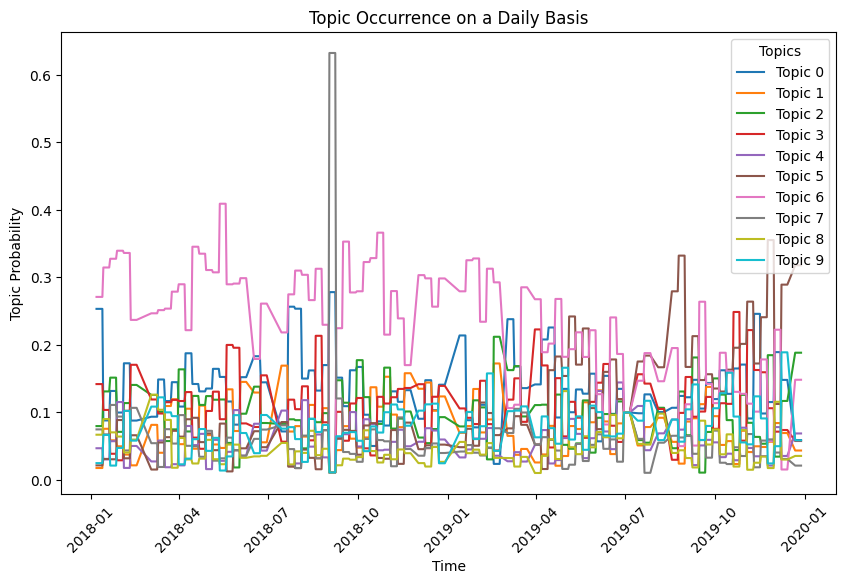

In [28]:
# Drop rows with any remaining missing values
daily_topics_df.dropna(inplace=True)

# Convert tuples to topic probabilities
daily_topics_df = daily_topics_df.applymap(lambda x: x[1])

# Plot each topic's occurrence on a daily basis using a line graph
plt.figure(figsize=(10, 6))
for topic in daily_topics_df.columns:
    plt.plot(daily_topics_df.index, daily_topics_df[topic], label=f"Topic {topic}")

plt.xlabel('Time')
plt.ylabel('Topic Probability')
plt.title('Topic Occurrence on a Daily Basis')
plt.legend(title='Topics', loc='upper right')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


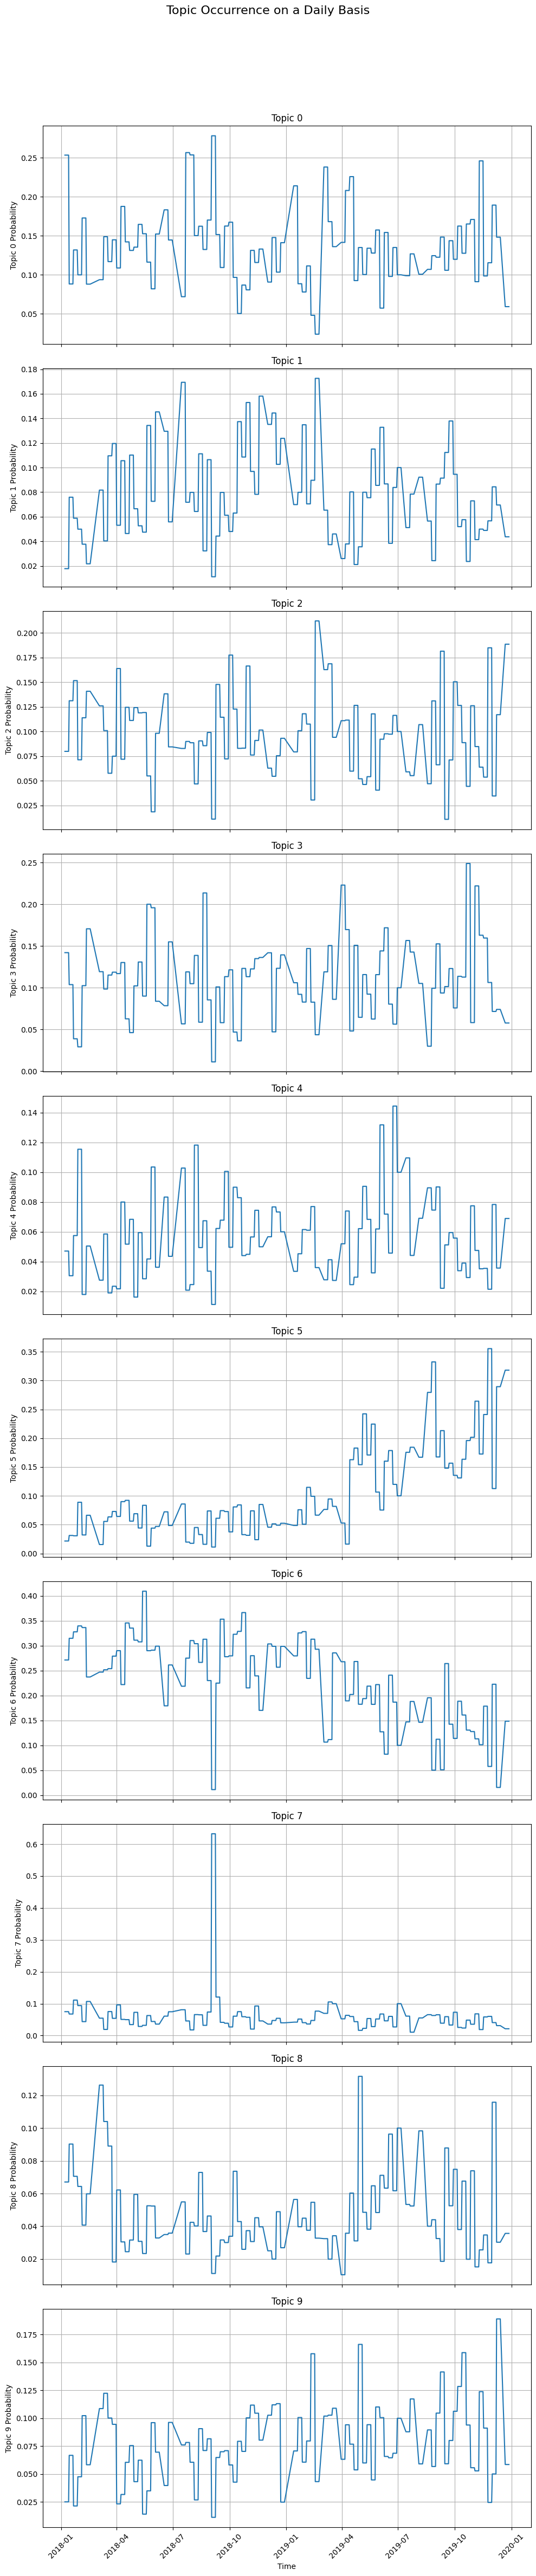

In [29]:
# Create a separate plot for each the topic
num_topics = daily_topics_df.shape[1]
fig, axs = plt.subplots(num_topics, 1, figsize=(10, 5*num_topics), sharex=True)

# Plot each topic's occurrence on a daily basis using a line graph
for i, topic in enumerate(daily_topics_df.columns):
    axs[i].plot(daily_topics_df.index, daily_topics_df[topic])
    axs[i].set_ylabel(f'Topic {topic} Probability')
    axs[i].grid(True)
    axs[i].set_title(f'Topic {topic}')

plt.xlabel('Time')
plt.suptitle('Topic Occurrence on a Daily Basis', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the subplot layout
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


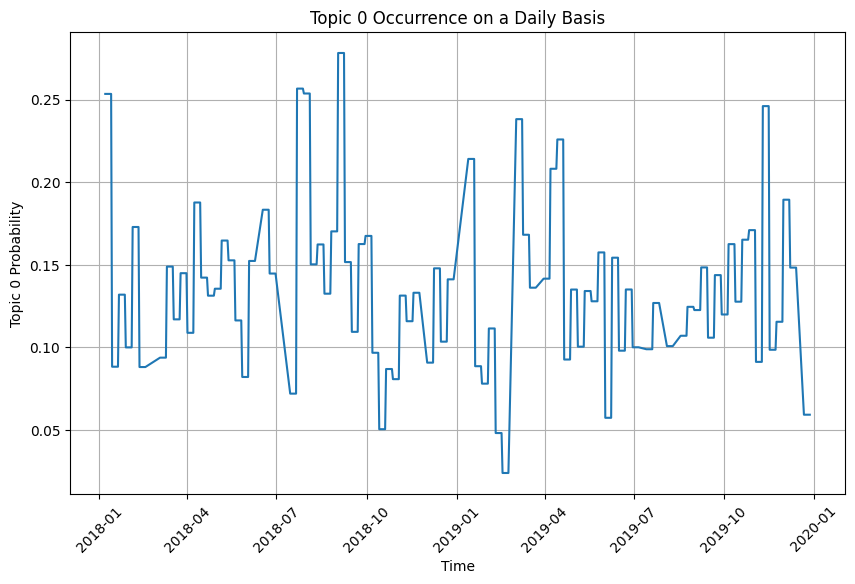

In [30]:
# Plot a single topic's occurrence on a daily basis using a line graph
topic_to_plot = 0  # Change this to the topic index you want to plot
topic_label = daily_topics_df.columns[topic_to_plot]

plt.figure(figsize=(10, 6))
plt.plot(daily_topics_df.index, daily_topics_df[topic_label])
plt.xlabel('Time')
plt.ylabel(f'Topic {topic_label} Probability')
plt.title(f'Topic {topic_label} Occurrence on a Daily Basis')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [31]:
import warnings

# Ignore a specific warning by category
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
# Find Granger causality of each topic with other topics
num_topics = daily_topics_df.shape[1]
granger_causality_results = {}

for topic in daily_topics_df.columns:
    granger_causality_results[topic] = {}
    for other_topic in daily_topics_df.columns:
        if topic != other_topic:
            # Combine the two topics' data to perform the Granger causality test
            combined_data = pd.concat([daily_topics_df[topic], daily_topics_df[other_topic]], axis=1)
            results = grangercausalitytests(combined_data, maxlag=1, verbose=False)

            # Get the p-value for the Granger causality test
            p_value = results[1][0]['ssr_ftest'][1]
            granger_causality_results[topic][other_topic] = p_value

# Print the Granger causality results
for topic in granger_causality_results:
    for other_topic, p_value in granger_causality_results[topic].items():
        print(f"Granger causality: {topic} -> {other_topic}, p-value: {p_value}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Granger causality: 0 -> 1, p-value: 0.3962138455396408
Granger causality: 0 -> 2, p-value: 0.4911755987711751
Granger causality: 0 -> 3, p-value: 0.34088723337056537
Granger causality: 0 -> 4, p-value: 0.7738192677115943
Granger causality: 0 -> 5, p-value: 0.5175954657603841
Granger causality: 0 -> 6, p-value: 0.9685754939480977
Granger causality: 0 -> 7, p-value: 0.582572868686698
Granger causality: 0 -> 8, p-value: 0.29611981052940495
Granger causality: 0 -> 9, p-value: 0.09556384192500886
Granger causality: 1 -> 0, p-value: 0.07301232587697958
Granger causality: 1 -> 2, p-value: 0.10130101335118899
Granger causality: 1 -> 3, p-value: 0.19237288831894553
Granger causality: 1 -> 4, p-value: 0.3185324111743387
Granger causality: 1 -> 5, p-value: 0.28508499470380877
Granger causality: 1 -> 6, p-value: 0.0511818067099764
Granger causality: 1 -> 7, p-value: 0.586841309946662
Granger causality: 1 -> 8, p-value: 0.8028492423714745
Granger causality: 1 -> 9, p-value: 0.5560563634429023
Grang

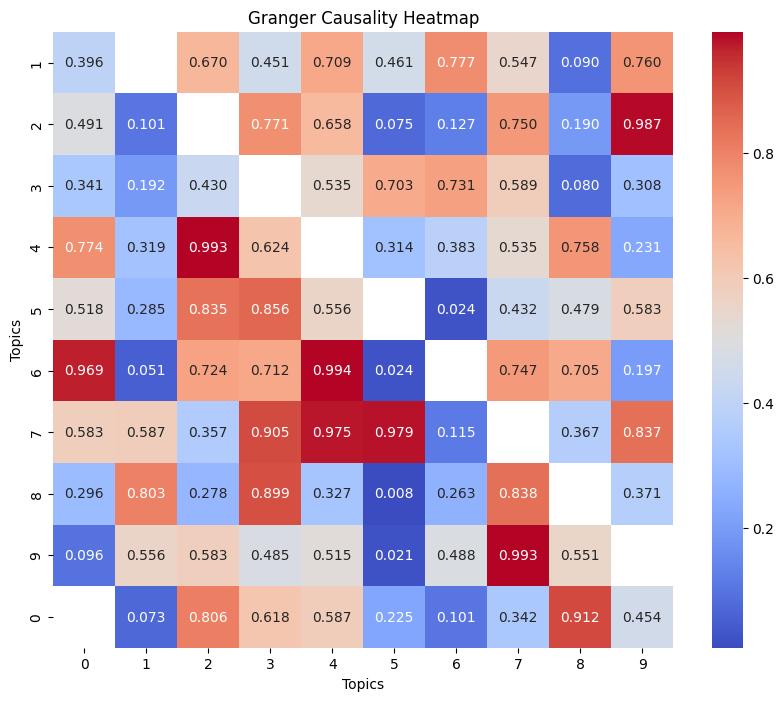

In [33]:
import seaborn as sns
# Convert the Granger causality results to a DataFrame
granger_df = pd.DataFrame(granger_causality_results)

# Plot the Granger causality results as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(granger_df, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Granger Causality Heatmap")
plt.xlabel("Topics")
plt.ylabel("Topics")
plt.show()

In [34]:
# Granger causality test results text
granger_results_text = """
Granger causality: 0 -> 1, p-value: 0.3962138455396408
Granger causality: 0 -> 2, p-value: 0.4911755987711751
Granger causality: 0 -> 3, p-value: 0.34088723337056537
Granger causality: 0 -> 4, p-value: 0.7738192677115943
Granger causality: 0 -> 5, p-value: 0.5175954657603841
Granger causality: 0 -> 6, p-value: 0.9685754939480977
Granger causality: 0 -> 7, p-value: 0.582572868686698
Granger causality: 0 -> 8, p-value: 0.29611981052940495
Granger causality: 0 -> 9, p-value: 0.09556384192500886
Granger causality: 1 -> 0, p-value: 0.07301232587697958
Granger causality: 1 -> 2, p-value: 0.10130101335118899
Granger causality: 1 -> 3, p-value: 0.19237288831894553
Granger causality: 1 -> 4, p-value: 0.3185324111743387
Granger causality: 1 -> 5, p-value: 0.28508499470380877
Granger causality: 1 -> 6, p-value: 0.0511818067099764
Granger causality: 1 -> 7, p-value: 0.586841309946662
Granger causality: 1 -> 8, p-value: 0.8028492423714745
Granger causality: 1 -> 9, p-value: 0.5560563634429023
Granger causality: 2 -> 0, p-value: 0.806327462022749
Granger causality: 2 -> 1, p-value: 0.6697756539614987
Granger causality: 2 -> 3, p-value: 0.4297844368006002
Granger causality: 2 -> 4, p-value: 0.9928742581736566
Granger causality: 2 -> 5, p-value: 0.8345740514498176
Granger causality: 2 -> 6, p-value: 0.7244365642454225
Granger causality: 2 -> 7, p-value: 0.35674907861570504
Granger causality: 2 -> 8, p-value: 0.27816093049702695
Granger causality: 2 -> 9, p-value: 0.5833128479944545
Granger causality: 3 -> 0, p-value: 0.6179523701140415
Granger causality: 3 -> 1, p-value: 0.45105420861364276
Granger causality: 3 -> 2, p-value: 0.7711338400435037
Granger causality: 3 -> 4, p-value: 0.6241086126882918
Granger causality: 3 -> 5, p-value: 0.8560949504057273
Granger causality: 3 -> 6, p-value: 0.7124166921346362
Granger causality: 3 -> 7, p-value: 0.9050804249392097
Granger causality: 3 -> 8, p-value: 0.899369487623248
Granger causality: 3 -> 9, p-value: 0.4851779671032095
Granger causality: 4 -> 0, p-value: 0.5868938255229913
Granger causality: 4 -> 1, p-value: 0.7094979160935508
Granger causality: 4 -> 2, p-value: 0.658119405757815
Granger causality: 4 -> 3, p-value: 0.5354304714914364
Granger causality: 4 -> 5, p-value: 0.556420624457761
Granger causality: 4 -> 6, p-value: 0.9936262704907591
Granger causality: 4 -> 7, p-value: 0.9749724531635994
Granger causality: 4 -> 8, p-value: 0.3267246967343056
Granger causality: 4 -> 9, p-value: 0.5154908502054871
Granger causality: 5 -> 0, p-value: 0.22533932320234973
Granger causality: 5 -> 1, p-value: 0.46082662608383784
Granger causality: 5 -> 2, p-value: 0.07529506869866966
Granger causality: 5 -> 3, p-value: 0.703075621412732
Granger causality: 5 -> 4, p-value: 0.31437340896153054
Granger causality: 5 -> 6, p-value: 0.02399034190903959
Granger causality: 5 -> 7, p-value: 0.9794515475933709
Granger causality: 5 -> 8, p-value: 0.007639409569321668
Granger causality: 5 -> 9, p-value: 0.020990571086497246
Granger causality: 6 -> 0, p-value: 0.10117334999714994
Granger causality: 6 -> 1, p-value: 0.777333152134847
Granger causality: 6 -> 2, p-value: 0.12700593467310967
Granger causality: 6 -> 3, p-value: 0.7311227695112215
Granger causality: 6 -> 4, p-value: 0.38304964683034215
Granger causality: 6 -> 5, p-value: 0.02379754718571032
Granger causality: 6 -> 7, p-value: 0.11510143169356744
Granger causality: 6 -> 8, p-value: 0.2633082801723149
Granger causality: 6 -> 9, p-value: 0.4882943215951351
Granger causality: 7 -> 0, p-value: 0.3422023462263015
Granger causality: 7 -> 1, p-value: 0.5470809488646902
Granger causality: 7 -> 2, p-value: 0.7503374163648845
Granger causality: 7 -> 3, p-value: 0.5889221446751964
Granger causality: 7 -> 4, p-value: 0.5349142001032934
Granger causality: 7 -> 5, p-value: 0.43172185536632146
Granger causality: 7 -> 6, p-value: 0.7469152184733253
Granger causality: 7 -> 8, p-value: 0.8375296543472037
Granger causality: 7 -> 9, p-value: 0.9932540935555934
Granger causality: 8 -> 0, p-value: 0.9117081064065937
Granger causality: 8 -> 1, p-value: 0.09017770238810129
Granger causality: 8 -> 2, p-value: 0.1904496721392654
Granger causality: 8 -> 3, p-value: 0.08016358994480519
Granger causality: 8 -> 4, p-value: 0.7582799200901964
Granger causality: 8 -> 5, p-value: 0.47919022224202457
Granger causality: 8 -> 6, p-value: 0.705262101108841
Granger causality: 8 -> 7, p-value: 0.36667749719892373
Granger causality: 8 -> 9, p-value: 0.5510200962597644
Granger causality: 9 -> 0, p-value: 0.45441530708614175
Granger causality: 9 -> 1, p-value: 0.7602700278459751
Granger causality: 9 -> 2, p-value: 0.9871448373486376
Granger causality: 9 -> 3, p-value: 0.3084878191332313
Granger causality: 9 -> 4, p-value: 0.23109428359473866
Granger causality: 9 -> 5, p-value: 0.582891668245044
Granger causality: 9 -> 6, p-value: 0.19651299001896036
Granger causality: 9 -> 7, p-value: 0.8373982270865735
Granger causality: 9 -> 8, p-value: 0.37070755053459625
"""

# this code split the  results text into lines
results_lines = granger_results_text.strip().split("\n")

# Initialize a list to store significant Granger causality pairs
significant_pairs = []

# Significance level
significance_level = 0.05

# Loop through the results lines
for line in results_lines:
    # Extract the p-value from the line
    p_value = float(line.split("p-value:")[1].strip())

    # If p-value is less than or equal to the significance level, then the Granger causality is significant
    if p_value <= significance_level:
        # Extract the topics from the line
        topics = line.split("->")
        source_topic = topics[0].strip()
        target_topic = topics[1].split(",")[0].strip()

        # Append the significant pair to the list
        significant_pairs.append((source_topic, target_topic))

# Print the significant Granger causality pairs
for cause, effect in significant_pairs:
    print(f"Granger causality exists from Topic {cause} to Topic {effect}")

Granger causality exists from Topic Granger causality: 5 to Topic 6
Granger causality exists from Topic Granger causality: 5 to Topic 8
Granger causality exists from Topic Granger causality: 5 to Topic 9
Granger causality exists from Topic Granger causality: 6 to Topic 5


#Test Set Data:


*   here we used the test set to test the perfomance of the Model
*   we conducted granger causality of the test set and causal pair was identified
*   We also check if the top words in train set exist in the test set







In [35]:
test_words = data_test['Description'].apply(preprocess_text)

In [36]:
test_dictionary = corpora.Dictionary(test_words)
test_corpus = [test_dictionary.doc2bow(text) for text in test_words]

In [37]:
test_topic_predictions = [lda_model[doc] for doc in test_corpus]

In [38]:
test_weekly_data = data_test.resample('W').agg({'Description': ' '.join})
 #Get topics for each week
test_weekly_topics = test_weekly_data['Description'].apply(get_document_topics)

In [41]:
# Convert weekly_topics to a DataFrame
test_topics_df = pd.DataFrame(test_weekly_topics.tolist(), index=test_weekly_topics.index)

# Resample the DataFrame to a daily frequency and forward-fill missing values
test_daily_topics_df = test_topics_df.resample('D').ffill()


In [42]:
# Drop rows with any remaining missing values
test_daily_topics_df.dropna(inplace=True)

# Convert tuples to topic probabilities
test_daily_topics_df = test_daily_topics_df.applymap(lambda x: x[1])

<ipython-input-42-ac38f71b44f3>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_daily_topics_df = test_daily_topics_df.applymap(lambda x: x[1])


In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
# Find Granger causality of each topic with other topics
num_topics = test_daily_topics_df.shape[1]
test_granger_causality_results = {}

for topic in test_daily_topics_df.columns:
    test_granger_causality_results[topic] = {}
    for other_topic in test_daily_topics_df.columns:
        if topic != other_topic:
            # Combine the two topics' data to perform the Granger causality test
            combined_data = pd.concat([test_daily_topics_df[topic], test_daily_topics_df[other_topic]], axis=1)
            results = grangercausalitytests(combined_data, maxlag=1, verbose=False)

            # Get the p-value for the Granger causality test
            p_value = results[1][0]['ssr_ftest'][1]
            test_granger_causality_results[topic][other_topic] = p_value

# Print the Granger causality results
for topic in test_granger_causality_results:
    for other_topic, p_value in test_granger_causality_results[topic].items():
        print(f"Granger causality: {topic} -> {other_topic}, p-value: {p_value}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Granger causality: 0 -> 1, p-value: 0.405499487830592
Granger causality: 0 -> 2, p-value: 0.5057281836878718
Granger causality: 0 -> 3, p-value: 0.45974827913949856
Granger causality: 0 -> 4, p-value: 0.64415990136014
Granger causality: 0 -> 5, p-value: 0.10637069668285729
Granger causality: 0 -> 6, p-value: 0.9607883557638393
Granger causality: 0 -> 7, p-value: 0.06924717725841903
Granger causality: 0 -> 8, p-value: 0.24577342416669282
Granger causality: 0 -> 9, p-value: 0.048100598362669264
Granger causality: 1 -> 0, p-value: 0.15307270986957502
Granger causality: 1 -> 2, p-value: 0.5720087724717213
Granger causality: 1 -> 3, p-value: 0.0828332517915253
Granger causality: 1 -> 4, p-value: 0.8462223757517076
Granger causality: 1 -> 5, p-value: 0.18116447464711677
Granger causality: 1 -> 6, p-value: 0.986653485326876
Granger causality: 1 -> 7, p-value: 0.8213473350372726
Granger causality: 1 -> 8, p-value: 0.5448055941495986
Granger causality: 1 -> 9, p-value: 0.5724876738521042
Grange

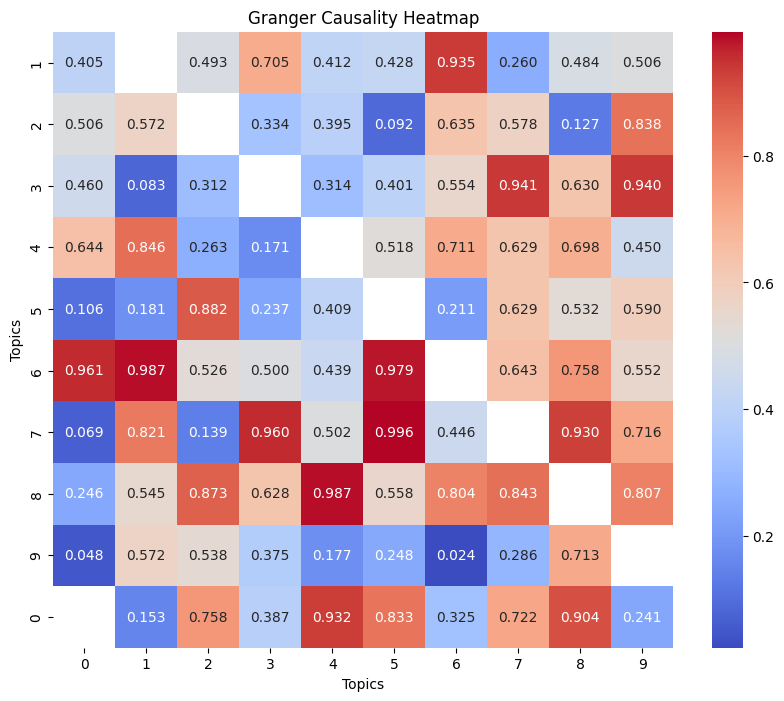

In [44]:
import seaborn as sns
# Convert the Granger causality results to a DataFrame
granger_df = pd.DataFrame(test_granger_causality_results)

# Plot the Granger causality results as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(granger_df, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("Granger Causality Heatmap")
plt.xlabel("Topics")
plt.ylabel("Topics")
plt.show()

In [45]:
# Granger causality test results text
test_granger_results_text = """
Granger causality: 0 -> 1, p-value: 0.4055694284126026
Granger causality: 0 -> 2, p-value: 0.5056572911961097
Granger causality: 0 -> 3, p-value: 0.45977020061640494
Granger causality: 0 -> 4, p-value: 0.64416668162941
Granger causality: 0 -> 5, p-value: 0.10638583849721918
Granger causality: 0 -> 6, p-value: 0.9607794383942608
Granger causality: 0 -> 7, p-value: 0.0692485889606334
Granger causality: 0 -> 8, p-value: 0.24581835500164617
Granger causality: 0 -> 9, p-value: 0.04808722935039603
Granger causality: 1 -> 0, p-value: 0.153095260498061
Granger causality: 1 -> 2, p-value: 0.5720784089655406
Granger causality: 1 -> 3, p-value: 0.08284743342729077
Granger causality: 1 -> 4, p-value: 0.8462041569478085
Granger causality: 1 -> 5, p-value: 0.18116889917464657
Granger causality: 1 -> 6, p-value: 0.9866522465463442
Granger causality: 1 -> 7, p-value: 0.821310263280801
Granger causality: 1 -> 8, p-value: 0.5448193334213538
Granger causality: 1 -> 9, p-value: 0.5724582178753155
Granger causality: 2 -> 0, p-value: 0.7584063328965347
Granger causality: 2 -> 1, p-value: 0.4928716744818942
Granger causality: 2 -> 3, p-value: 0.31153594241278926
Granger causality: 2 -> 4, p-value: 0.2634195146215702
Granger causality: 2 -> 5, p-value: 0.8824042609855178
Granger causality: 2 -> 6, p-value: 0.5256409743259316
Granger causality: 2 -> 7, p-value: 0.13888834284496687
Granger causality: 2 -> 8, p-value: 0.8730922439481422
Granger causality: 2 -> 9, p-value: 0.5385250036935045
Granger causality: 3 -> 0, p-value: 0.3871837564388645
Granger causality: 3 -> 1, p-value: 0.7048840014983694
Granger causality: 3 -> 2, p-value: 0.33347827371817984
Granger causality: 3 -> 4, p-value: 0.1709741560586117
Granger causality: 3 -> 5, p-value: 0.23742286321205827
Granger causality: 3 -> 6, p-value: 0.4999604223044455
Granger causality: 3 -> 7, p-value: 0.9598933742016078
Granger causality: 3 -> 8, p-value: 0.6276185164343538
Granger causality: 3 -> 9, p-value: 0.37484481181852525
Granger causality: 4 -> 0, p-value: 0.9315878791826652
Granger causality: 4 -> 1, p-value: 0.4123193801131976
Granger causality: 4 -> 2, p-value: 0.39532700127454445
Granger causality: 4 -> 3, p-value: 0.3140511545089056
Granger causality: 4 -> 5, p-value: 0.40934803602880243
Granger causality: 4 -> 6, p-value: 0.4390524396882476
Granger causality: 4 -> 7, p-value: 0.5024932637199273
Granger causality: 4 -> 8, p-value: 0.9873865566499617
Granger causality: 4 -> 9, p-value: 0.176714489006661
Granger causality: 5 -> 0, p-value: 0.8329215278934233
Granger causality: 5 -> 1, p-value: 0.42845204644403767
Granger causality: 5 -> 2, p-value: 0.09153350921983391
Granger causality: 5 -> 3, p-value: 0.4014553215157143
Granger causality: 5 -> 4, p-value: 0.5184728450522968
Granger causality: 5 -> 6, p-value: 0.9785367087665716
Granger causality: 5 -> 7, p-value: 0.9954968209575447
Granger causality: 5 -> 8, p-value: 0.5577837460885102
Granger causality: 5 -> 9, p-value: 0.24790913021173003
Granger causality: 6 -> 0, p-value: 0.3250561682041764
Granger causality: 6 -> 1, p-value: 0.9353301526338159
Granger causality: 6 -> 2, p-value: 0.6346565772907925
Granger causality: 6 -> 3, p-value: 0.5544370148978304
Granger causality: 6 -> 4, p-value: 0.7105587724303601
Granger causality: 6 -> 5, p-value: 0.21099405709396432
Granger causality: 6 -> 7, p-value: 0.44595503320249263
Granger causality: 6 -> 8, p-value: 0.803794608169904
Granger causality: 6 -> 9, p-value: 0.023737210182945327
Granger causality: 7 -> 0, p-value: 0.7216261955906097
Granger causality: 7 -> 1, p-value: 0.26044423329604943
Granger causality: 7 -> 2, p-value: 0.5780402914695186
Granger causality: 7 -> 3, p-value: 0.9414427300709989
Granger causality: 7 -> 4, p-value: 0.6288183502203771
Granger causality: 7 -> 5, p-value: 0.629188159187297
Granger causality: 7 -> 6, p-value: 0.6432350609389669
Granger causality: 7 -> 8, p-value: 0.8425739240956005
Granger causality: 7 -> 9, p-value: 0.28642845710959525
Granger causality: 8 -> 0, p-value: 0.9038418778368779
Granger causality: 8 -> 1, p-value: 0.48366278000729546
Granger causality: 8 -> 2, p-value: 0.12728498261727392
Granger causality: 8 -> 3, p-value: 0.6298110110599211
Granger causality: 8 -> 4, p-value: 0.6982872538159413
Granger causality: 8 -> 5, p-value: 0.5323793073521441
Granger causality: 8 -> 6, p-value: 0.7578055955483853
Granger causality: 8 -> 7, p-value: 0.9298460310106346
Granger causality: 8 -> 9, p-value: 0.7134950888405067
Granger causality: 9 -> 0, p-value: 0.24069534167893628
Granger causality: 9 -> 1, p-value: 0.5058112302017896
Granger causality: 9 -> 2, p-value: 0.8376497260635591
Granger causality: 9 -> 3, p-value: 0.9403871302121439
Granger causality: 9 -> 4, p-value: 0.4504427627067328
Granger causality: 9 -> 5, p-value: 0.5896771611539188
Granger causality: 9 -> 6, p-value: 0.5515659218735539
Granger causality: 9 -> 7, p-value: 0.716108476148706
Granger causality: 9 -> 8, p-value: 0.8069318571241808
"""

# this code split the  results text into lines
results_lines = test_granger_results_text.strip().split("\n")

# Initialize a list to store significant Granger causality pairs
significant_pairs = []

# Significance level
significance_level = 0.05

# Loop through the results lines
for line in results_lines:
    # Extract the p-value from the line
    p_value = float(line.split("p-value:")[1].strip())

    # If p-value is less than or equal to the significance level, then the Granger causality is significant
    if p_value <= significance_level:
        # Extract the topics from the line
        topics = line.split("->")
        source_topic = topics[0].strip()
        target_topic = topics[1].split(",")[0].strip()

        # Append the significant pair to the list
        significant_pairs.append((source_topic, target_topic))

# Print the significant Granger causality pairs
for cause, effect in significant_pairs:
    print(f"Granger causality exists from Topic {cause} to Topic {effect}")

Granger causality exists from Topic Granger causality: 0 to Topic 9
Granger causality exists from Topic Granger causality: 6 to Topic 9


In [46]:
for i in range(10):  # Print topics for the first 5 test documents
    print(f"Test Document {i + 1} Topics: {test_topic_predictions[i]}")

Test Document 1 Topics: [(1, 0.3348064), (2, 0.62071115)]
Test Document 2 Topics: [(1, 0.39476797), (2, 0.092822924), (8, 0.47098294)]
Test Document 3 Topics: [(1, 0.20320064), (2, 0.27607277), (3, 0.11496505), (5, 0.0566889), (8, 0.23907779), (9, 0.09174877)]
Test Document 4 Topics: [(1, 0.071952805), (2, 0.33893707), (4, 0.19528998), (8, 0.095362194), (9, 0.26715234)]
Test Document 5 Topics: [(0, 0.13818578), (1, 0.09428407), (2, 0.36346072), (3, 0.066621855), (4, 0.12327134), (7, 0.13000442), (8, 0.067479774)]
Test Document 6 Topics: [(1, 0.11525225), (2, 0.072729886), (6, 0.60072523), (7, 0.07732603), (8, 0.10597558)]
Test Document 7 Topics: [(2, 0.46180063), (5, 0.14208603), (6, 0.30433825), (8, 0.05795796)]
Test Document 8 Topics: [(2, 0.23480356), (6, 0.13111784), (8, 0.590223)]
Test Document 9 Topics: [(0, 0.08273257), (2, 0.21367677), (3, 0.2629043), (5, 0.08455309), (6, 0.10067166), (8, 0.23039055)]
Test Document 10 Topics: [(1, 0.09608563), (2, 0.088738814), (5, 0.11004292),

Test Document 1 Topics:
Topic 1: Probability 0.3348064124584198


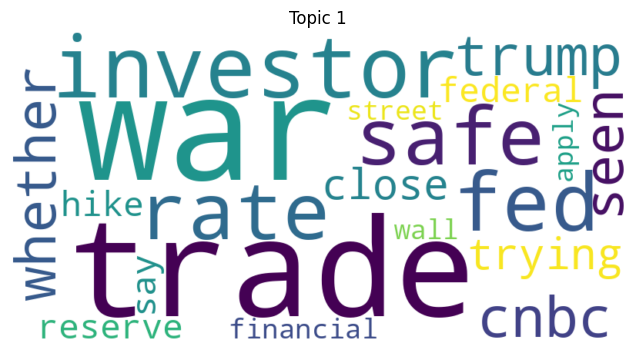

Topic 2: Probability 0.6207111477851868


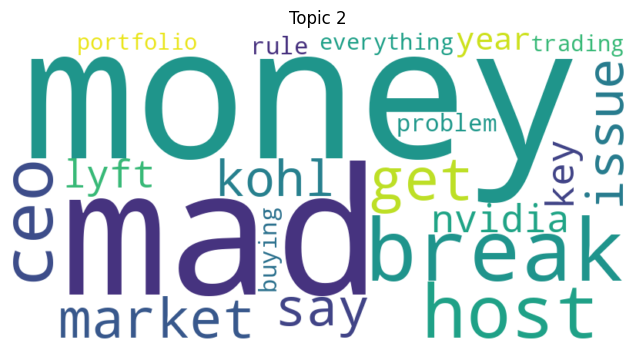

Test Document 2 Topics:
Topic 1: Probability 0.39476796984672546


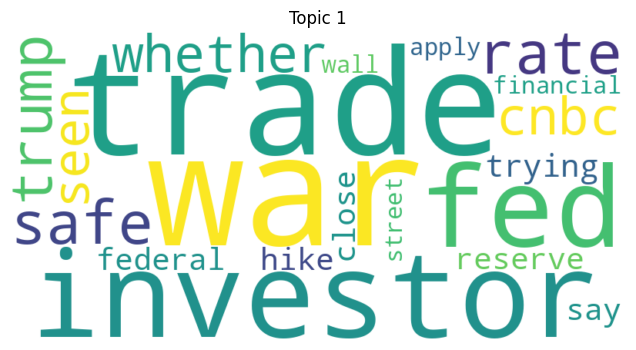

Topic 2: Probability 0.09282292425632477


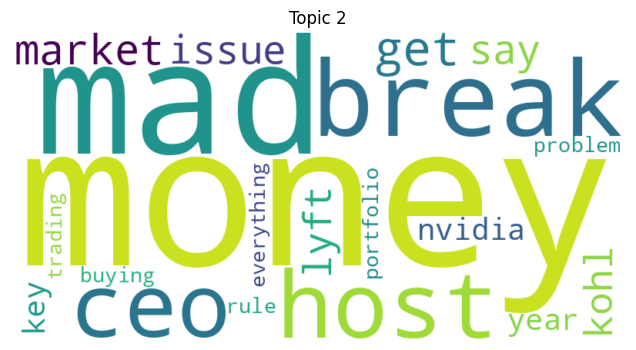

Topic 8: Probability 0.47098293900489807


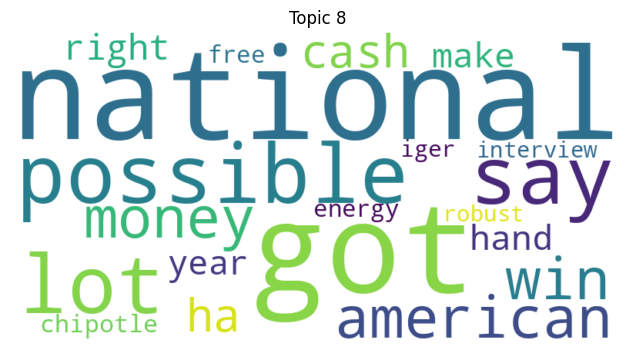

Test Document 3 Topics:
Topic 1: Probability 0.20320063829421997


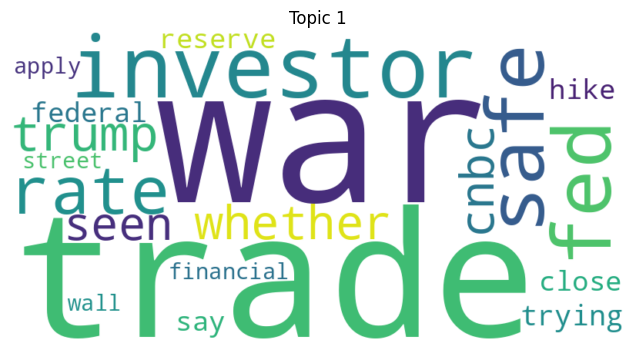

Topic 2: Probability 0.27607277035713196


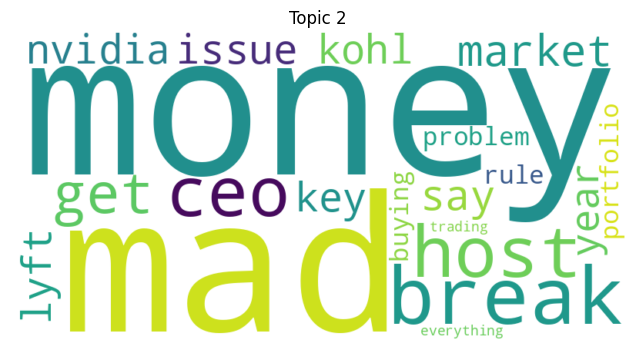

Topic 3: Probability 0.1149650514125824


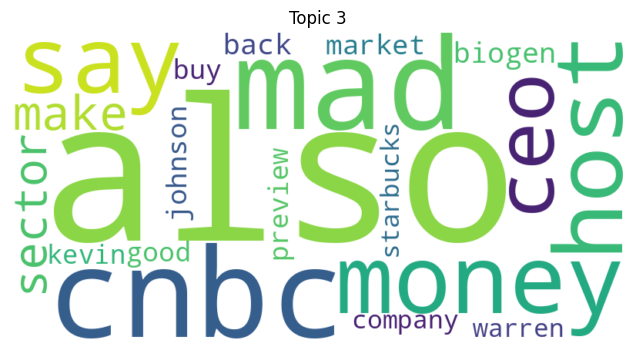

Topic 5: Probability 0.05668890103697777


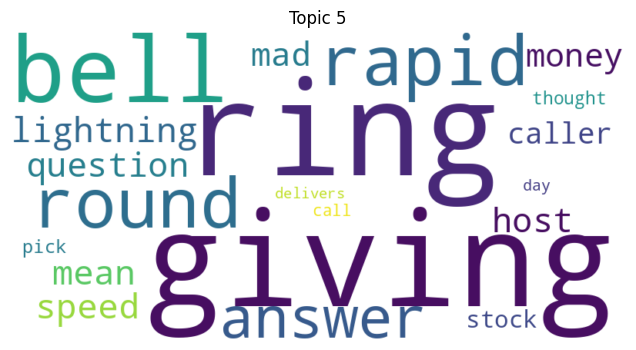

Topic 8: Probability 0.23907779157161713


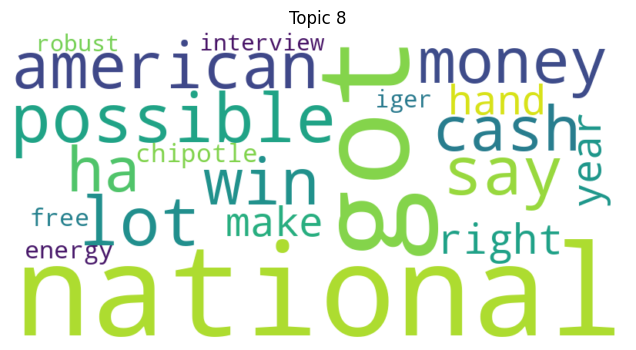

Topic 9: Probability 0.09174876660108566


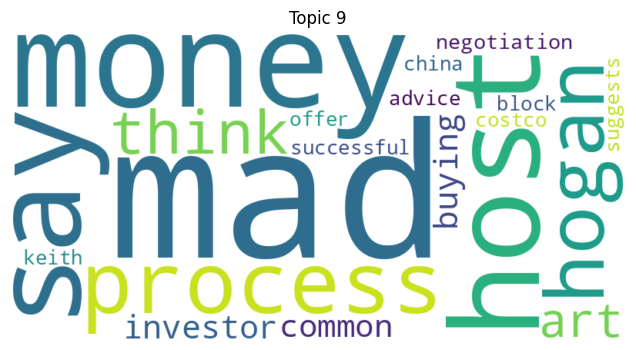

Test Document 4 Topics:
Topic 1: Probability 0.07195280492305756


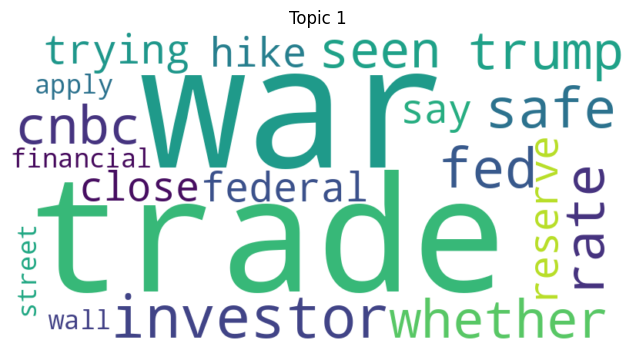

Topic 2: Probability 0.33893707394599915


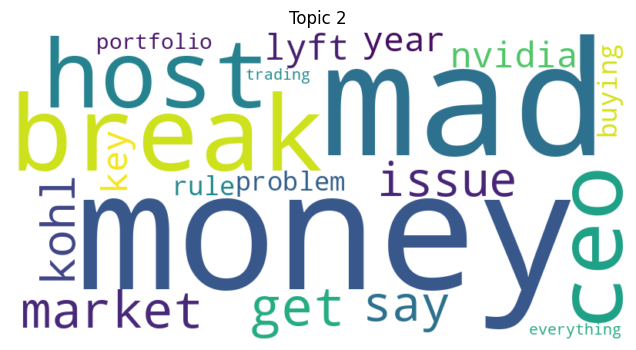

Topic 4: Probability 0.1952899843454361


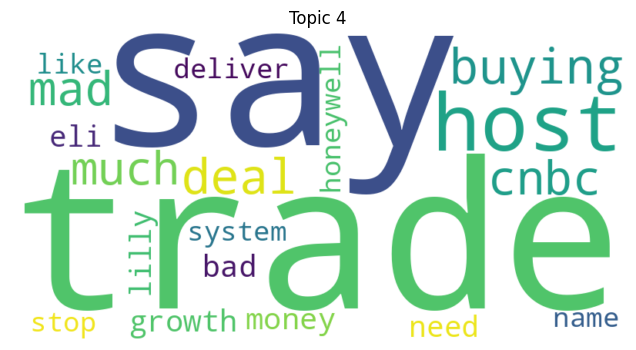

Topic 8: Probability 0.09536219388246536


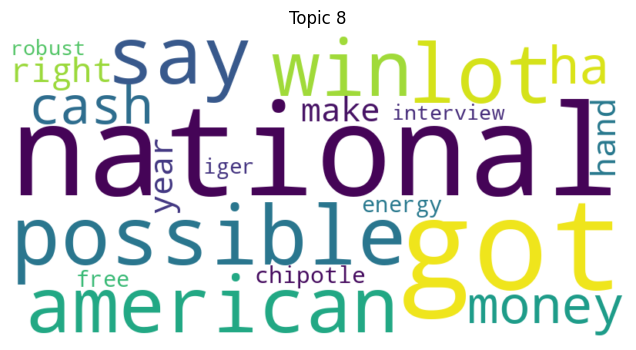

Topic 9: Probability 0.267152339220047


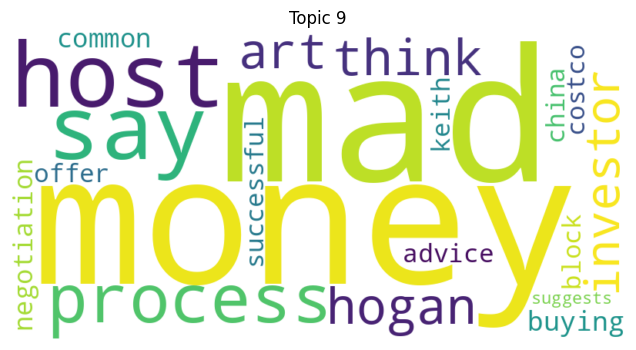

Test Document 5 Topics:
Topic 0: Probability 0.1381857842206955


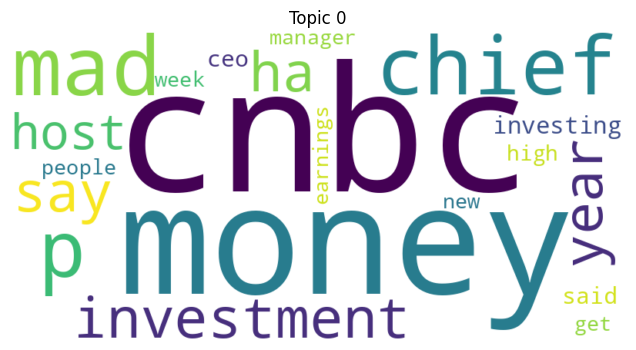

Topic 1: Probability 0.0942840725183487


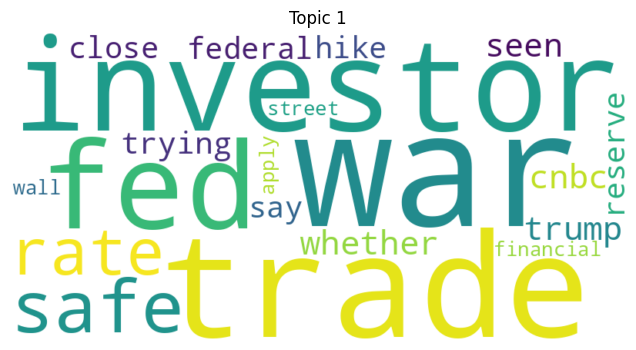

Topic 2: Probability 0.3634607195854187


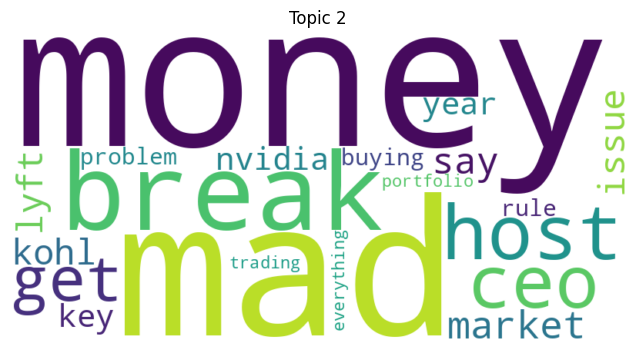

Topic 3: Probability 0.06662185490131378


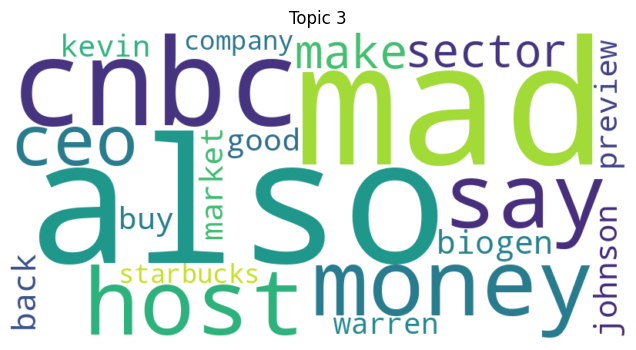

Topic 4: Probability 0.12327133864164352


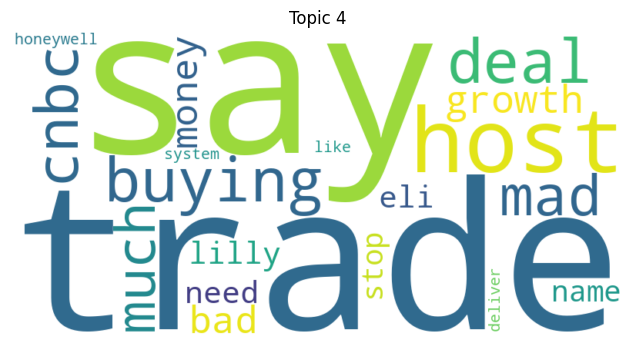

Topic 7: Probability 0.130004420876503


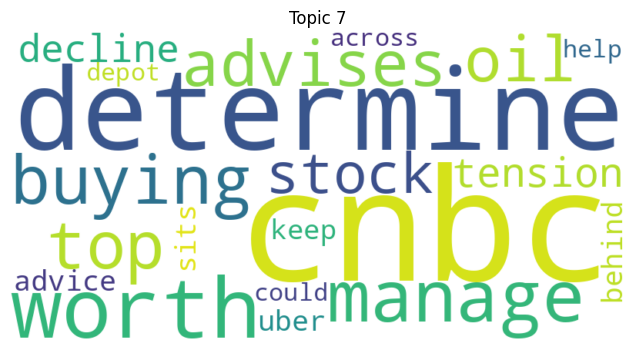

Topic 8: Probability 0.06747977435588837


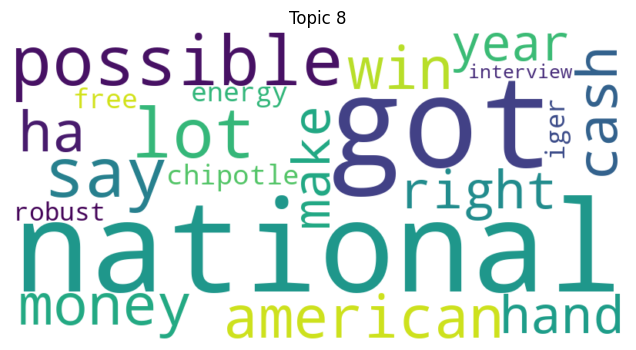

In [47]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#this function to create a word cloud for a given topic distribution
def create_word_cloud(topic_distribution, topic_id):
    words = lda_model.show_topic(topic_id, topn=20)  # Get the top 20 words for the topic
    word_dict = {word: prob for word, prob in words}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_id}")
    plt.axis("off")
    plt.show()

# Visualize topics for the first 5 test documents
for i in range(5):
    print(f"Test Document {i + 1} Topics:")
    for topic_id, topic_prob in test_topic_predictions[i]:
        print(f"Topic {topic_id}: Probability {topic_prob}")
        create_word_cloud(topic_prob, topic_id)

In [48]:

test_corpus_tfidf = tfidf[test_corpus]

#use the lda_model to get the topics for the test corpus
test_lda_topics = lda_model[test_corpus_tfidf]

# Print topics and associated words for the test data
for i, doc_topics in enumerate(test_lda_topics):
    print(f"Document {i} Topics:")
    for topic_id, prob in doc_topics:
        print(f"Topic {topic_id} (Probability: {prob}):")
        print(lda_model.print_topic(topic_id, topn=5))  # Print top 5 words for the topic

Streaming output truncated to the last 5000 lines.
Topic 9 (Probability: 0.03184177353978157):
0.018*"mad" + 0.017*"money" + 0.014*"host" + 0.014*"say" + 0.010*"process"
Document 322 Topics:
Topic 0 (Probability: 0.09975997358560562):
0.018*"cnbc" + 0.013*"money" + 0.013*"mad" + 0.012*"chief" + 0.012*"p"
Topic 1 (Probability: 0.025526465848088264):
0.015*"war" + 0.013*"trade" + 0.013*"investor" + 0.011*"fed" + 0.011*"safe"
Topic 2 (Probability: 0.0255243219435215):
0.016*"money" + 0.015*"mad" + 0.014*"break" + 0.012*"host" + 0.011*"ceo"
Topic 3 (Probability: 0.025522928684949875):
0.017*"also" + 0.016*"mad" + 0.016*"cnbc" + 0.015*"money" + 0.014*"host"
Topic 4 (Probability: 0.025522928684949875):
0.017*"trade" + 0.017*"say" + 0.013*"host" + 0.012*"buying" + 0.012*"deal"
Topic 5 (Probability: 0.09276308864355087):
0.048*"ring" + 0.048*"giving" + 0.048*"bell" + 0.047*"rapid" + 0.047*"round"
Topic 6 (Probability: 0.21824268996715546):
0.022*"including" + 0.019*"take" + 0.018*"favorite" + 

In [49]:

# Print topics and associated words for the test data
for i, doc_topics in enumerate(test_lda_topics):
    print(f"Document {i} Topics:")
    for topic_id, prob in doc_topics:
        print(f"Topic {topic_id} (Probability: {prob}):")
        print(lda_model.print_topic(topic_id, topn=5))  # Print top 5 words for the topic


Streaming output truncated to the last 5000 lines.
Topic 9 (Probability: 0.03184718266129494):
0.018*"mad" + 0.017*"money" + 0.014*"host" + 0.014*"say" + 0.010*"process"
Document 322 Topics:
Topic 0 (Probability: 0.09975914657115936):
0.018*"cnbc" + 0.013*"money" + 0.013*"mad" + 0.012*"chief" + 0.012*"p"
Topic 1 (Probability: 0.02552645653486252):
0.015*"war" + 0.013*"trade" + 0.013*"investor" + 0.011*"fed" + 0.011*"safe"
Topic 2 (Probability: 0.025524316355586052):
0.016*"money" + 0.015*"mad" + 0.014*"break" + 0.012*"host" + 0.011*"ceo"
Topic 3 (Probability: 0.025522923097014427):
0.017*"also" + 0.016*"mad" + 0.016*"cnbc" + 0.015*"money" + 0.014*"host"
Topic 4 (Probability: 0.025522923097014427):
0.017*"trade" + 0.017*"say" + 0.013*"host" + 0.012*"buying" + 0.012*"deal"
Topic 5 (Probability: 0.092762790620327):
0.048*"ring" + 0.048*"giving" + 0.048*"bell" + 0.047*"rapid" + 0.047*"round"
Topic 6 (Probability: 0.21824543178081512):
0.022*"including" + 0.019*"take" + 0.018*"favorite" + 0

In [ ]:


# Print out the topics for the first 5 documents in the test corpus
for i, doc_topics in enumerate(test_lda_topics[:5]):
    print(f"Document {i} Topics:")
    for topic_id, prob in doc_topics:
        print(f"Topic {topic_id} (Probability: {prob}):")


In [ ]:
print(df)

In [50]:
# Assuming you have the lda_model, test_corpus_tfidf, and test_dictionary defined

# Calculate the perplexity
perplexity = lda_model.log_perplexity(test_corpus_tfidf)

print(f"Perplexity on Test Set: {perplexity}")


Perplexity on Test Set: -35.06259622941338


In [ ]:
for i in range(10):  # Print topics for the first 5 test documents
    print(f"Test Document {i + 1} Topics: {test_topic_predictions[i]}")

Test Document 1 Topics:
Topic 1: Probability 0.3348064124584198


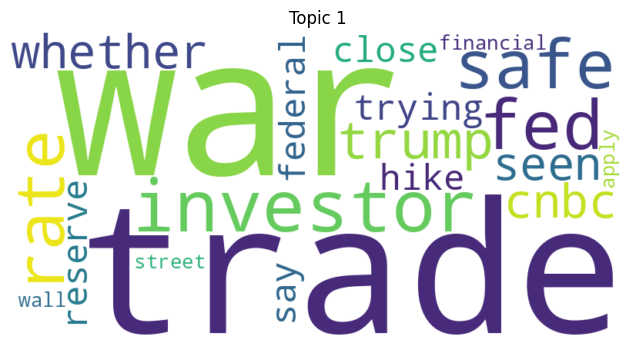

Topic 2: Probability 0.6207111477851868


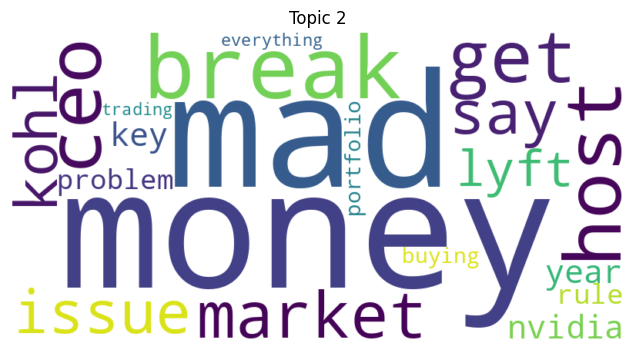

Test Document 2 Topics:
Topic 1: Probability 0.39476796984672546


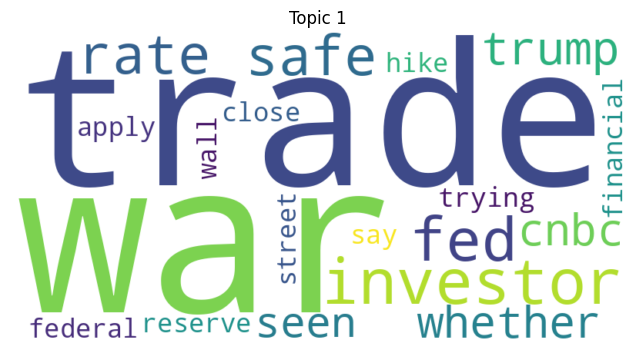

Topic 2: Probability 0.09282292425632477


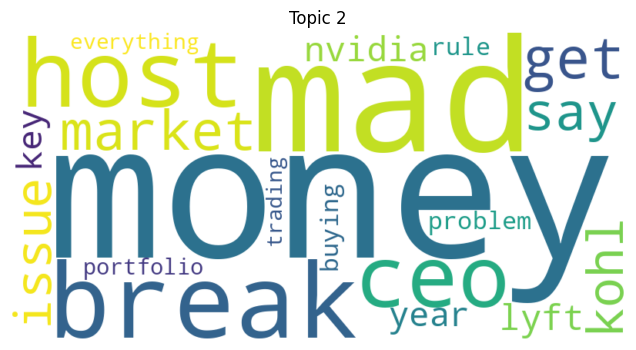

Topic 8: Probability 0.47098293900489807


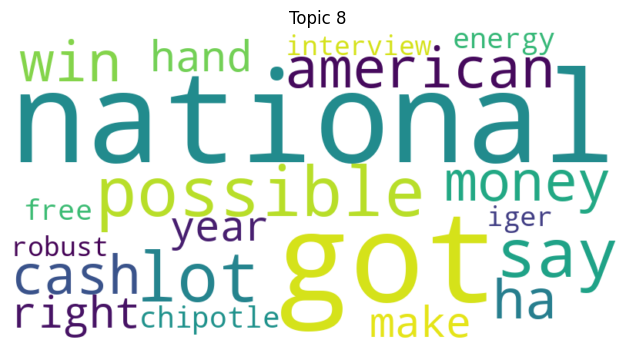

Test Document 3 Topics:
Topic 1: Probability 0.20320063829421997


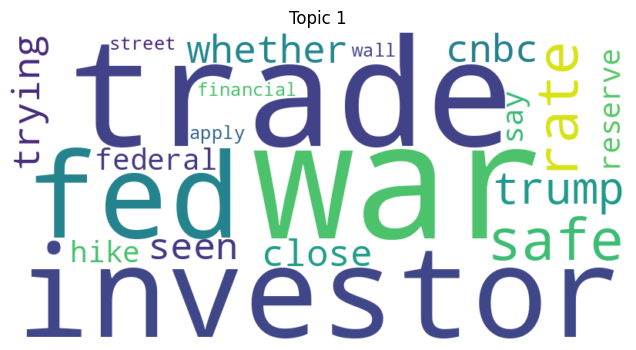

Topic 2: Probability 0.27607277035713196


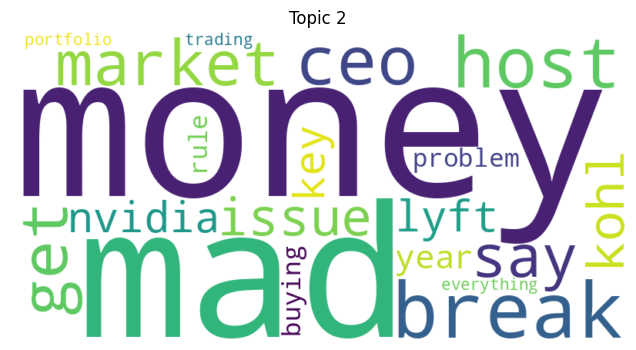

Topic 3: Probability 0.1149650514125824


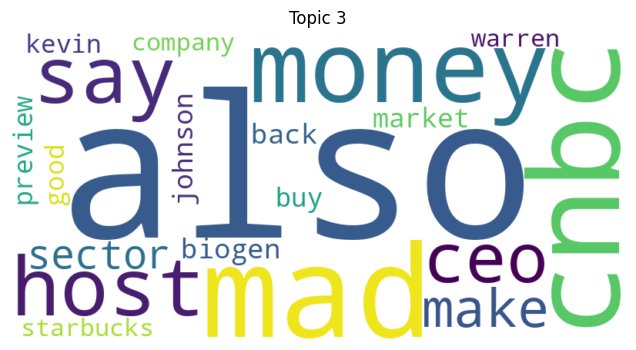

Topic 5: Probability 0.05668890103697777


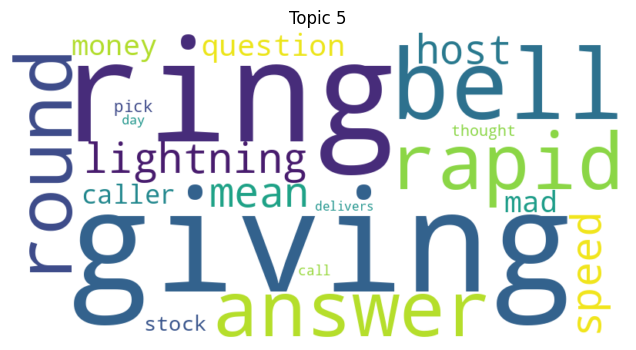

Topic 8: Probability 0.23907779157161713


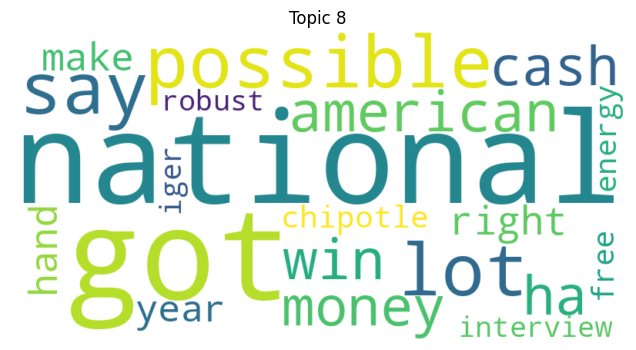

Topic 9: Probability 0.09174876660108566


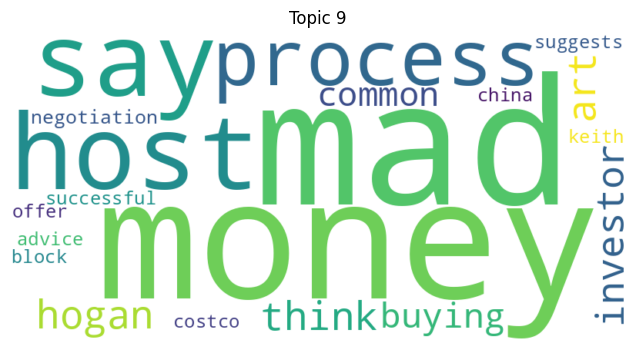

Test Document 4 Topics:
Topic 1: Probability 0.07195280492305756


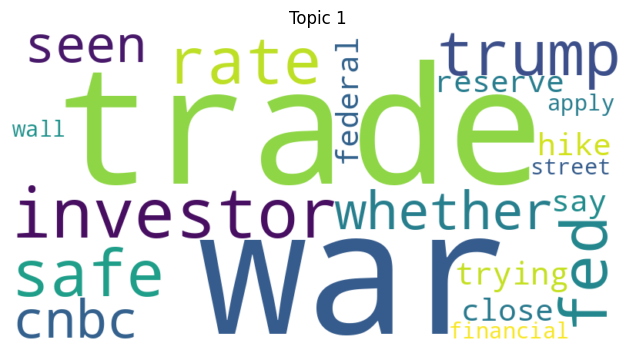

Topic 2: Probability 0.33893707394599915


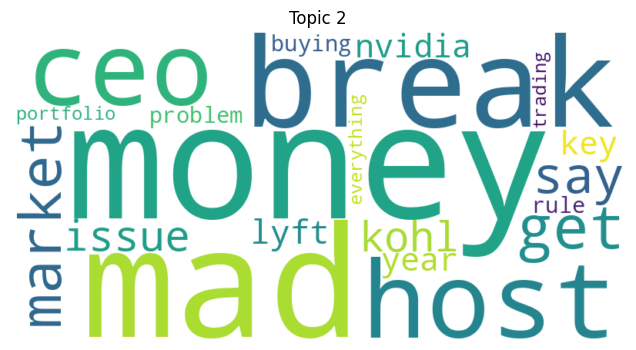

Topic 4: Probability 0.1952899843454361


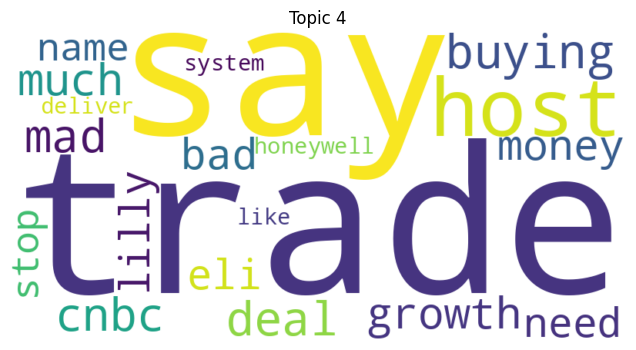

Topic 8: Probability 0.09536219388246536


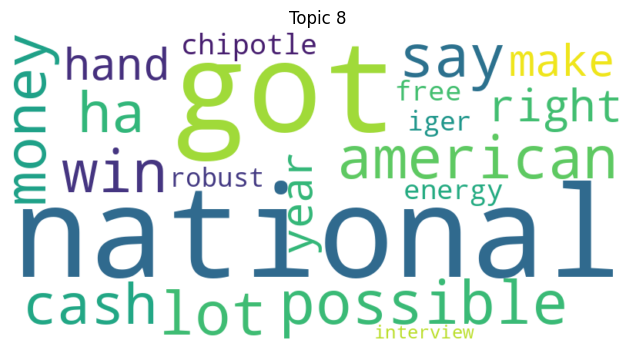

Topic 9: Probability 0.267152339220047


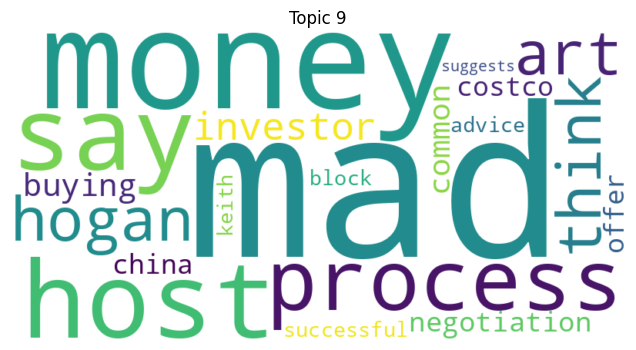

Test Document 5 Topics:
Topic 0: Probability 0.1381857842206955


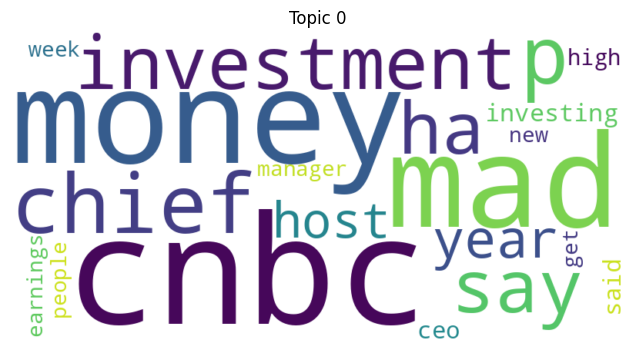

Topic 1: Probability 0.0942840725183487


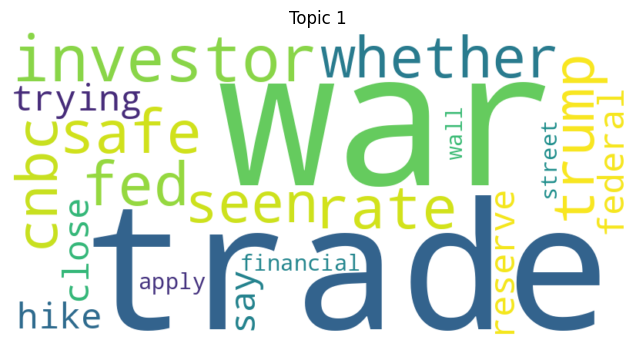

Topic 2: Probability 0.3634607195854187


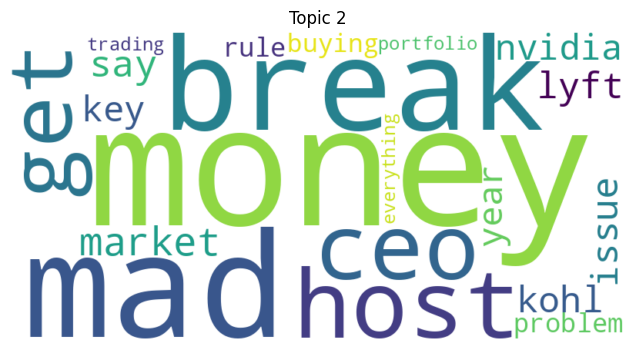

Topic 3: Probability 0.06662185490131378


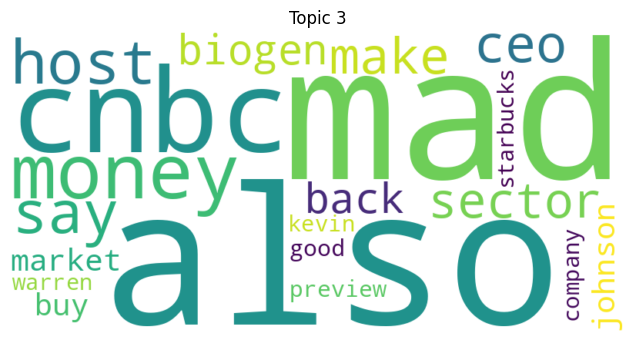

Topic 4: Probability 0.12327133864164352


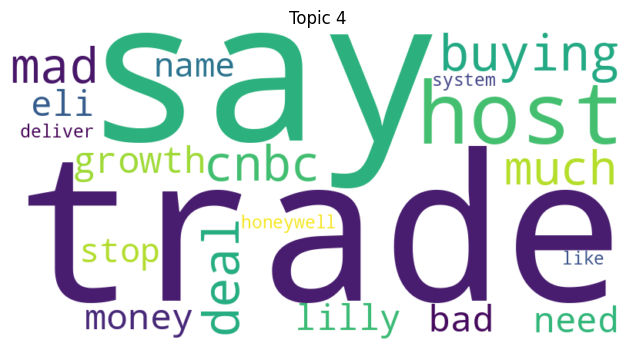

Topic 7: Probability 0.130004420876503


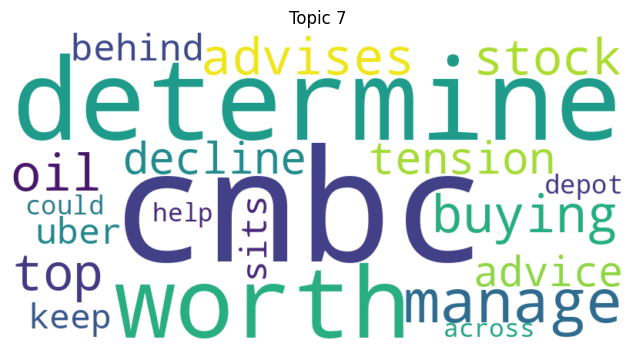

Topic 8: Probability 0.06747977435588837


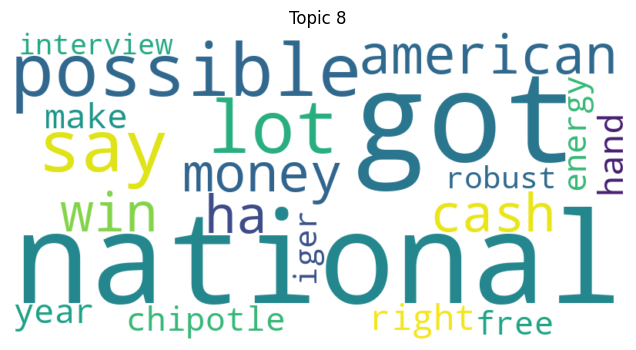

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#this function to create a word cloud for a given topic distribution
def create_word_cloud(topic_distribution, topic_id):
    words = lda_model.show_topic(topic_id, topn=20)  # Get the top 20 words for the topic
    word_dict = {word: prob for word, prob in words}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_id}")
    plt.axis("off")
    plt.show()

# Visualize topics for the first 5 test documents
for i in range(5):
    print(f"Test Document {i + 1} Topics:")
    for topic_id, topic_prob in test_topic_predictions[i]:
        print(f"Topic {topic_id}: Probability {topic_prob}")
        create_word_cloud(topic_prob, topic_id)


In [52]:
# Define a function to get the top topic for each document
def get_top_topic(doc_topic_distribution):
    return max(doc_topic_distribution, key=lambda item: item[1])

# Print the top topics for the test documents
for i, doc_topics in enumerate(test_topic_predictions):
    top_topic = get_top_topic(doc_topics)
    print(f"Test Document {i + 1} Top Topic: Topic {top_topic[0]}, Probability: {top_topic[1]:.4f}")


Test Document 1 Top Topic: Topic 2, Probability: 0.6207
Test Document 2 Top Topic: Topic 8, Probability: 0.4710
Test Document 3 Top Topic: Topic 2, Probability: 0.2761
Test Document 4 Top Topic: Topic 2, Probability: 0.3389
Test Document 5 Top Topic: Topic 2, Probability: 0.3635
Test Document 6 Top Topic: Topic 6, Probability: 0.6007
Test Document 7 Top Topic: Topic 2, Probability: 0.4618
Test Document 8 Top Topic: Topic 8, Probability: 0.5902
Test Document 9 Top Topic: Topic 3, Probability: 0.2629
Test Document 10 Top Topic: Topic 6, Probability: 0.5704
Test Document 11 Top Topic: Topic 5, Probability: 0.2991
Test Document 12 Top Topic: Topic 1, Probability: 0.2546
Test Document 13 Top Topic: Topic 2, Probability: 0.4577
Test Document 14 Top Topic: Topic 7, Probability: 0.3438
Test Document 15 Top Topic: Topic 9, Probability: 0.2905
Test Document 16 Top Topic: Topic 2, Probability: 0.4744
Test Document 17 Top Topic: Topic 4, Probability: 0.4672
Test Document 18 Top Topic: Topic 3, Pro

#Calculating z-scores to find the spikes in topics

In [53]:
# daily_topics_df contains your data for the train split
topic_5_data = daily_topics_df[5]  # Replace 'Topic_5' with the actual column name

# Step 1: Calculate the mean and standard deviation of Topic 5
mean_topic_5 = topic_5_data.mean()
std_dev_topic_5 = topic_5_data.std()

# Step 2: Compute the z-scores
z_scores_topic_5 = (topic_5_data - mean_topic_5) / std_dev_topic_5

# Step 3: Find the day with the maximum z-score
max_z_score_day = z_scores_topic_5.idxmax()

# Print the results
print(f"Day of maximum spike for Topic 5: {max_z_score_day}")
print(f"z-score:{z_scores_topic_5}")


Day of maximum spike for Topic 5: 2019-11-24 00:00:00
z-score:Time
2018-01-07   -1.060699
2018-01-08   -1.060699
2018-01-09   -1.060699
2018-01-10   -1.060699
2018-01-11   -1.060699
                ...   
2019-12-24    2.672455
2019-12-25    2.672455
2019-12-26    2.672455
2019-12-27    2.672455
2019-12-28    2.672455
Name: 5, Length: 623, dtype: float32


In [56]:
# Assuming daily_topics_df contains your data
# Assuming 'Topic_8' is the actual column name for Topic 8

# Step 1: Filter data for November 25, 2019
topic_8_data_nov_25 = test_daily_topics_df[8]

# Step 2: Calculate the mean and standard deviation of Topic 8
mean_topic_8 = topic_8_data_nov_25.mean()
std_dev_topic_8 = topic_8_data_nov_25.std()

# Step 3: Compute the z-scores for Topic 8 on November 25, 2019
z_scores_topic_8_nov_25 = (topic_8_data_nov_25 - mean_topic_8) / std_dev_topic_8

# Step 3: Find the day with the maximum z-score
max_z_score_day = z_scores_topic_8_nov_25.idxmax()
# Print the z-scores for Topic 8 on November 25, 2019

# Print the results
print(f"Day of maximum spike for Topic 5: {max_z_score_day}")
print(f"Z-scores for Topic 8 on 2019-11-25:")
print(z_scores_topic_8_nov_25)


Day of maximum spike for Topic 5: 2020-04-05 00:00:00
Z-scores for Topic 8 on 2019-11-25:
Time
2020-01-12    1.540864
2020-01-13    1.540864
2020-01-14    1.540864
2020-01-15    1.540864
2020-01-16    1.540864
                ...   
2020-06-30    0.411796
2020-07-01    0.411796
2020-07-02    0.411796
2020-07-03    0.411796
2020-07-04    0.411796
Name: 8, Length: 154, dtype: float32


In [57]:
mean = daily_topics_df.mean()
std_dev = daily_topics_df.std()

In [58]:
z_scores = (daily_topics_df - mean) / std_dev

In [59]:
threshold = 1  # Adjust as needed
spike_indices = z_scores[z_scores > threshold].stack().index
spikes = daily_topics_df.loc[spike_indices.get_level_values('Time')]

In [60]:
print(spikes)


                   0         1         2         3         4         5  \
Time                                                                     
2018-01-07  0.253469  0.017752  0.079857  0.142058  0.047044  0.021623   
2018-01-08  0.253469  0.017752  0.079857  0.142058  0.047044  0.021623   
2018-01-09  0.253469  0.017752  0.079857  0.142058  0.047044  0.021623   
2018-01-10  0.253469  0.017752  0.079857  0.142058  0.047044  0.021623   
2018-01-11  0.253469  0.017752  0.079857  0.142058  0.047044  0.021623   
...              ...       ...       ...       ...       ...       ...   
2019-12-26  0.059151  0.043671  0.188525  0.057758  0.068933  0.317979   
2019-12-27  0.059151  0.043671  0.188525  0.057758  0.068933  0.317979   
2019-12-27  0.059151  0.043671  0.188525  0.057758  0.068933  0.317979   
2019-12-28  0.059151  0.043671  0.188525  0.057758  0.068933  0.317979   
2019-12-28  0.059151  0.043671  0.188525  0.057758  0.068933  0.317979   

                   6         7       

In [61]:

threshold = -1  # Adjust as needed
spike_indices = z_scores[z_scores > threshold].stack().index
spikes = z_scores.loc[spike_indices.get_level_values('Time')]

# Print the Z-scores that meet the threshold condition
print(spikes)

                   0         1         2         3         4         5  \
Time                                                                     
2018-01-07  2.417596 -1.616981 -0.426433  0.693689 -0.354387 -1.060699   
2018-01-07  2.417596 -1.616981 -0.426433  0.693689 -0.354387 -1.060699   
2018-01-07  2.417596 -1.616981 -0.426433  0.693689 -0.354387 -1.060699   
2018-01-07  2.417596 -1.616981 -0.426433  0.693689 -0.354387 -1.060699   
2018-01-07  2.417596 -1.616981 -0.426433  0.693689 -0.354387 -1.060699   
...              ...       ...       ...       ...       ...       ...   
2019-12-28 -1.553499 -0.929120  2.192014 -1.106659  0.431873  2.672455   
2019-12-28 -1.553499 -0.929120  2.192014 -1.106659  0.431873  2.672455   
2019-12-28 -1.553499 -0.929120  2.192014 -1.106659  0.431873  2.672455   
2019-12-28 -1.553499 -0.929120  2.192014 -1.106659  0.431873  2.672455   
2019-12-28 -1.553499 -0.929120  2.192014 -1.106659  0.431873  2.672455   

                   6         7       

In [ ]:
#Test Data

#Sentiment Analysis

> This section of sentiment analysis applied to topics derived from a Latent Dirichlet Allocation (LDA) model. This code snippet processes a collection of documents, calculates their sentiment scores using the TextBlob sentiment analysis tool, and then associates these sentiment scores with the dominant topic assigned to each document by the LDA model. Finally, it calculates and prints the average sentiment scores for each topic.

*   initializing an empty dictionary
*   obtains the topic probabilities for the document using the LDA model
*   calculates the average sentiment scores for each topic
*   List item






In [63]:
import gensim
import pandas as pd
from gensim import models
from gensim import corpora
from textblob import TextBlob
from collections import defaultdict

data_train
# Create a DataFrame
data_df = pd.DataFrame(data_train)

# Define the dictionary and LDA model (replace with your actual dictionary and model)
dictionary
lda_model

# Initialize sentiment dictionaries
sentiment_cause = {}
sentiment_effect = {}

# Define topic indices for cause and effect
EFFECT_TOPIC = 5
CAUSE_TOPIC = 8

# Iterate through the DataFrame rows
for date, row in data_df.iterrows():
    date_str = date.strftime("%Y-%m-%d")  # Convert the datetime index to a string in time format of the data
    text_data = row['Description']

    # Calculate sentiment score using TextBlob
    sent_score = round(TextBlob(text_data).sentiment.polarity, 2)

    # Convert text data to bag of words
    bow_text = dictionary.doc2bow(text_data.split())

    # Get the topic distribution
    topic_dist = lda_model[bow_text]

    # Find the topic with the highest score
    if not topic_dist:
        continue

    top_topic = max(topic_dist, key=lambda x: x[1])
    topic_index = top_topic[0]

    # Update sentiment dictionaries based on the topic
    if topic_index == EFFECT_TOPIC:
        sentiment_effect[date_str] = sentiment_effect.get(date_str, 0) + sent_score
    elif topic_index == CAUSE_TOPIC:
        sentiment_cause[date_str] = sentiment_cause.get(date_str, 0) + sent_score

print("Sentiment scores for EFFECT_TOPIC:")
for date, score in sentiment_effect.items():
    print(f"Date: {date}, Score: {score}")

print("\nSentiment scores for CAUSE_TOPIC:")
for date, score in sentiment_cause.items():
    print(f"Date: {date}, Score: {score}")

Sentiment scores for EFFECT_TOPIC:
Date: 2018-01-03, Score: 0.0
Date: 2018-01-11, Score: 0.0
Date: 2018-01-23, Score: -0.3
Date: 2018-02-02, Score: 0.0
Date: 2018-02-07, Score: 0.0
Date: 2018-02-08, Score: 0.0
Date: 2018-03-02, Score: 0.0
Date: 2018-03-12, Score: 0.35
Date: 2018-03-13, Score: 0.0
Date: 2018-03-21, Score: 0.17
Date: 2018-03-27, Score: 0.0
Date: 2018-04-02, Score: 0.25
Date: 2018-04-09, Score: 0.0
Date: 2018-04-11, Score: 0.0
Date: 2018-04-20, Score: 0.0
Date: 2018-04-24, Score: -0.2
Date: 2018-05-03, Score: 1.0
Date: 2018-05-23, Score: 0.1
Date: 2018-06-01, Score: 0.43
Date: 2018-07-11, Score: -0.31
Date: 2018-08-22, Score: 0.0
Date: 2018-08-23, Score: -0.25
Date: 2018-09-20, Score: 0.5
Date: 2018-09-25, Score: -0.16
Date: 2018-10-02, Score: 0.03
Date: 2018-10-11, Score: 0.0
Date: 2018-11-02, Score: 0.0
Date: 2018-11-12, Score: 0.04
Date: 2018-11-13, Score: -0.2
Date: 2018-11-16, Score: 0.1
Date: 2018-12-18, Score: 0.5
Date: 2019-01-23, Score: -0.2
Date: 2019-01-29, Sco

#Sentiment analysis for the second topic pairs with higher causality

In [64]:
import gensim
import pandas as pd
from gensim import models
from gensim import corpora
from textblob import TextBlob
from collections import defaultdict

data_train
# Create a DataFrame
data_df = pd.DataFrame(data_train)

# Define the dictionary and LDA model (replace with your actual dictionary and model)
dictionary
lda_model

# Initialize sentiment dictionaries
sentiment_cause = {}
sentiment_effect = {}

# Define topic indices for cause and effect
EFFECT_TOPIC = 0
CAUSE_TOPIC = 2

# Iterate through the DataFrame rows
for date, row in data_df.iterrows():
    date_str = date.strftime("%Y-%m-%d")  # Convert the datetime index to a string in time format of the data
    text_data = row['Description']

    # Calculate sentiment score using TextBlob
    sent_score = round(TextBlob(text_data).sentiment.polarity, 2)

    # Convert text data to bag of words
    bow_text = dictionary.doc2bow(text_data.split())

    # Get the topic distribution
    topic_dist = lda_model[bow_text]

    # Find the topic with the highest score
    if not topic_dist:
        continue

    top_topic = max(topic_dist, key=lambda x: x[1])
    topic_index = top_topic[0]

    # Update sentiment dictionaries based on the topic
    if topic_index == EFFECT_TOPIC:
        sentiment_effect[date_str] = sentiment_effect.get(date_str, 0) + sent_score
    elif topic_index == CAUSE_TOPIC:
        sentiment_cause[date_str] = sentiment_cause.get(date_str, 0) + sent_score

print("Sentiment scores for EFFECT_TOPIC:")
for date, score in sentiment_effect.items():
    print(f"Date: {date}, Score: {score}")

print("\nSentiment scores for CAUSE_TOPIC:")
for date, score in sentiment_cause.items():
    print(f"Date: {date}, Score: {score}")

Sentiment scores for EFFECT_TOPIC:
Date: 2018-01-05, Score: -3.92
Date: 2018-01-08, Score: 0.0
Date: 2018-01-12, Score: 0.0
Date: 2018-01-16, Score: 0.06
Date: 2018-01-17, Score: 0.0
Date: 2018-01-18, Score: 0.14
Date: 2018-01-22, Score: 0.0
Date: 2018-01-29, Score: 0.06
Date: 2018-02-01, Score: -0.08
Date: 2018-02-06, Score: 0.9400000000000001
Date: 2018-02-07, Score: 0.0
Date: 2018-02-08, Score: -0.16
Date: 2018-02-19, Score: 0.05
Date: 2018-02-21, Score: 0.25
Date: 2018-02-28, Score: -0.32
Date: 2018-03-06, Score: 0.43
Date: 2018-03-07, Score: -0.19
Date: 2018-03-08, Score: -0.16
Date: 2018-03-09, Score: -0.02
Date: 2018-03-13, Score: 0.0
Date: 2018-03-15, Score: -0.16
Date: 2018-03-16, Score: 0.0
Date: 2018-03-19, Score: -0.28
Date: 2018-03-20, Score: 0.28
Date: 2018-03-22, Score: 0.06
Date: 2018-03-23, Score: -0.79
Date: 2018-03-28, Score: -0.31
Date: 2018-04-03, Score: 0.15000000000000002
Date: 2018-04-04, Score: 0.0
Date: 2018-04-06, Score: 0.3
Date: 2018-04-09, Score: 0.47
Date

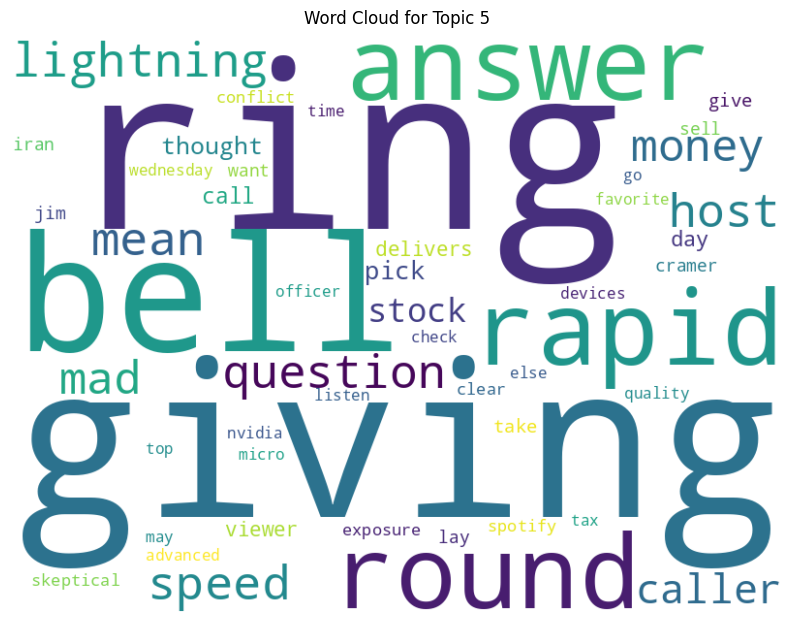

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Replace this with your LDA model and topic ID
topic_id = 5
topic_word_dist = lda_model.get_topic_terms(topic_id, topn=50)  # Get the top 50 words in the topic

# Create a dictionary of words and their probabilities
word_probabilities = {lda_model.id2word[id]: prob for id, prob in topic_word_dist}

# Create a WordCloud instance
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_probabilities)

# Display the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Topic {topic_id}")
plt.axis('off')
plt.show()


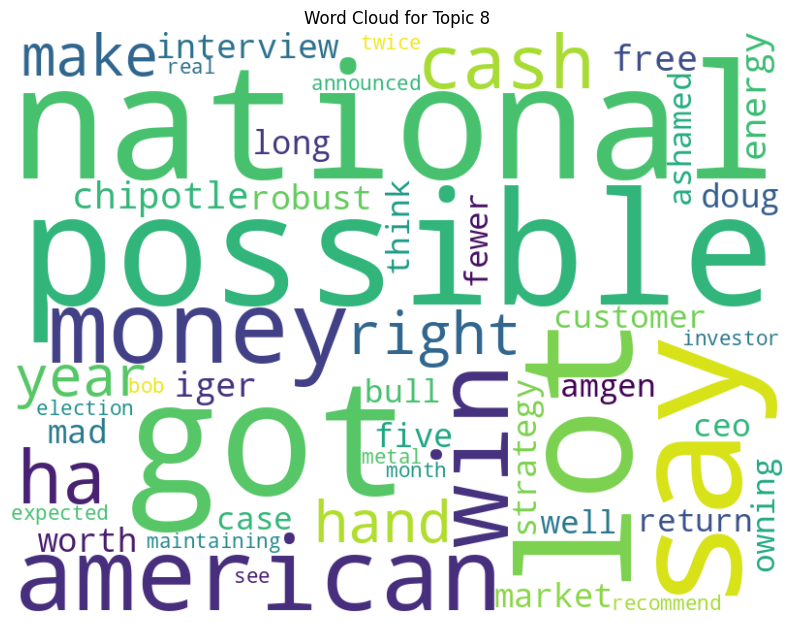

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Replace this with your LDA model and topic ID
topic_id = 8
topic_word_dist = lda_model.get_topic_terms(topic_id, topn=50)  # Get the top 50 words in the topic

# Create a dictionary of words and their probabilities
word_probabilities = {lda_model.id2word[id]: prob for id, prob in topic_word_dist}

# Create a WordCloud instance
wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_probabilities)

# Display the WordCloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f"Word Cloud for Topic {topic_id}")
plt.axis('off')
plt.show()


#Topic inference

In [ ]:
topic_inferences = []

for doc_bow in corpus:
    document_topics = lda_model.get_document_topics(doc_bow)
    topic_inferences.append(document_topics)

# Print topic inferences for each document
for doc_idx, document_topics in enumerate(topic_inferences):
    print(f"Document {doc_idx + 1} - Topic Inference:")
    for topic_id, topic_prob in document_topics:
        print(f"Topic {topic_id} - Probability: {topic_prob:.4f}")
    print()



In [ ]:
# Assuming `topic_inferences` contains the topic inferences for each document
num_topics = 10
# Initialize a list to store the total probabilities for each topic
total_probabilities = [0] * num_topics

# Initialize a counter to keep track of the number of documents
num_documents = len(topic_inferences)

# Loop through each document's topic inferences
for document_topics in topic_inferences:
    # Accumulate the probabilities for each topic
    for topic_id, topic_prob in document_topics:
        total_probabilities[topic_id] += topic_prob

# Calculate the average probability for each topic
average_probabilities = [total_prob / num_documents for total_prob in total_probabilities]

# Print average probability for each topic
for topic_id, avg_prob in enumerate(average_probabilities):
    print(f"Topic {topic_id} - Average Probability: {avg_prob:.4f}")


#Model Evaluation.

In [70]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

perplexity = lda_model.log_perplexity(test_corpus)

print(f'Perplexity: {perplexity}')


Perplexity: -25.380971080794207


In [71]:
# Compute coherence score to evaluate the model
coherence_model = CoherenceModel(model=lda_model, texts=all_words, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
normalized_coherence_score = round(coherence_score, 4)
print(f'Normalized Coherence Score: {normalized_coherence_score}')

Normalized Coherence Score: 0.4098


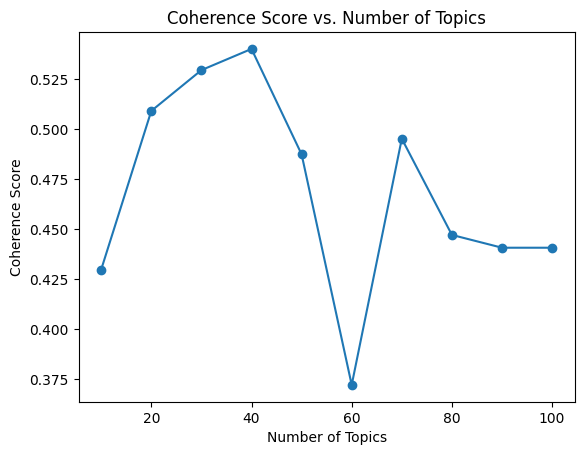

In [72]:
import matplotlib.pyplot as plt

# Define the number of topics and their corresponding coherence scores
num_topics = [10, 20, 30, 40, 50, 60, 70, 80, 90,100]
coherence_scores = [0.4297, 0.509, 0.5294, 0.54, 0.4873, 0.372, 0.4951, 0.447, 0.4406, 0.4406]

# Create a line plot
plt.plot(num_topics, coherence_scores, marker='o')



# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')

# Show the plot
plt.show()


In [73]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.model_selection import KFold
import numpy as np

num_folds = 5

coherence_scores = []

# Define a range of N values (number of topics)
num_topics_list = [ 10, 15, 20, 30,  40,  50, 50,  70, 80,  90, 100]

# Initialize k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for num_topics in num_topics_list:
    print(f"Evaluating model with {num_topics} topics...")
    for train_index, test_index in kf.split(corpus_tfidf):
        train_corpus = [corpus_tfidf[i] for i in train_index]
        test_corpus = [corpus_tfidf[i] for i in test_index]

        # Train an LDA model
        lda_model = LdaModel(corpus=train_corpus, num_topics=num_topics, id2word=dictionary)

        # Calculate coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=all_words, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)

        print(f"Coherence Score: {coherence_score}")

# Calculate average coherence score for each k value
average_coherence_scores = []
for i in range(len(num_topics_list)):
    start_idx = i * num_folds
    end_idx = (i + 1) * num_folds
    average_score = np.mean(coherence_scores[start_idx:end_idx])
    average_coherence_scores.append(average_score)

# Find the best number of topics based on the highest average coherence score
best_num_topics = num_topics_list[np.argmax(average_coherence_scores)]

print(f"The best number of topics is: {best_num_topics}")


Evaluating model with 10 topics...


Coherence Score: 0.30622454423871426


Coherence Score: 0.2891899064279033


Coherence Score: 0.28284493203516153


Coherence Score: 0.31866537066365624


Coherence Score: 0.28603097358796536
Evaluating model with 15 topics...


Coherence Score: 0.281903106871581
Coherence Score: 0.2977253293076884


Coherence Score: 0.2968160879540588


Coherence Score: 0.2905185971510859


Coherence Score: 0.2754056421972095
Evaluating model with 20 topics...


Coherence Score: 0.30583257854601037


Coherence Score: 0.29410502951646034


Coherence Score: 0.28781201183478233


Coherence Score: 0.30479614230565505


Coherence Score: 0.3017269958506975
Evaluating model with 30 topics...


Coherence Score: 0.35811368193369736
Coherence Score: 0.34086631698133896


Coherence Score: 0.371784428250378


Coherence Score: 0.34584979456132214


Coherence Score: 0.3596047911811626
Evaluating model with 40 topics...


Coherence Score: 0.38190649588482295


Coherence Score: 0.40023650618009654


Coherence Score: 0.4155816046767969


Coherence Score: 0.4211502831764209


Coherence Score: 0.4089932876290618
Evaluating model with 50 topics...


Coherence Score: 0.45819581091336603


Coherence Score: 0.45939197297391976


Coherence Score: 0.45536412163229867


Coherence Score: 0.47971118572578036


Coherence Score: 0.47431949589170996
Evaluating model with 50 topics...


Coherence Score: 0.4702846723361468


Coherence Score: 0.46862655244822976


Coherence Score: 0.46862622368061496


Coherence Score: 0.46661425699026643


Coherence Score: 0.4763586870491252
Evaluating model with 70 topics...


Coherence Score: 0.4885632077277896


Coherence Score: 0.46849467390666033


Coherence Score: 0.49393417308435134


Coherence Score: 0.4955171253643185


Coherence Score: 0.5177161514850982
Evaluating model with 80 topics...


Coherence Score: 0.45203912126359214


Coherence Score: 0.45203912126359214


Coherence Score: 0.458449352810824


Coherence Score: 0.45203912126359214


Coherence Score: 0.45203912126359214
Evaluating model with 90 topics...


Coherence Score: 0.4520391212635922


Coherence Score: 0.4520391212635922


Coherence Score: 0.4520391212635922


Coherence Score: 0.4520391212635922


Coherence Score: 0.4520391212635922
Evaluating model with 100 topics...


Coherence Score: 0.4520391212635923


Coherence Score: 0.4520391212635923


Coherence Score: 0.4520391212635923


Coherence Score: 0.4520391212635923
Coherence Score: 0.4520391212635923
The best number of topics is: 70


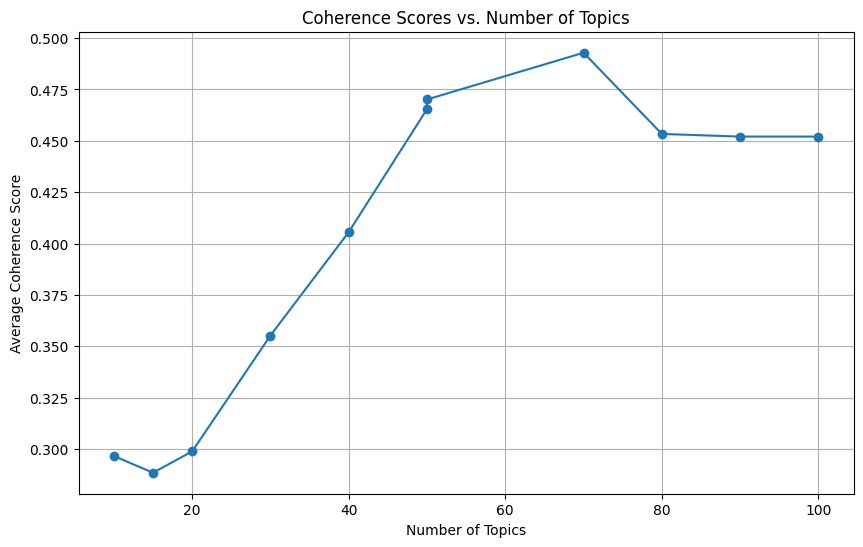

In [74]:
import matplotlib.pyplot as plt

# Calculate average coherence score for each k value
average_coherence_scores = []
for i in range(len(num_topics_list)):
    start_idx = i * num_folds
    end_idx = (i + 1) * num_folds
    average_score = np.mean(coherence_scores[start_idx:end_idx])
    average_coherence_scores.append(average_score)

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, average_coherence_scores, marker='o', linestyle='-')
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.grid(True)

# Show the plot
plt.show()


#Topic Evaluation

In [ ]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel

# Calculate perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

In [ ]:
#all_words
# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=all_words, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")